In [1]:
from tqdm import tqdm
import os
import jax.random as random
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
from scipy.special import gammaln, log1p, expit
from pathlib import Path
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats     import gaussian_kde
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from __future__ import annotations
import numpy as np
import xarray as xr
from typing import List, Dict, Any
import os
from pathlib import Path
import numpy as np
import pandas as pd
import jax.random as random
import jax.numpy as jnp
import arviz as az
from numpyro.infer import MCMC, NUTS
from datetime import date

rng = np.random.default_rng(42)

## Utilities for plotting and saving beta densities

In [2]:
# Save beta density histograms as JPEG files
def save_beta_density_hist(
        idata,
        *,
        output_folder: str | Path,
        experiment: str,
        regex: str = r"beta_\d+",
        bins: int = 40,
        dpi: int = 300,
):
    """
    One figure per beta variable (KDE + histogram) written to
    {output_folder}/{experiment}_{varname}.jpg.
    Histogram now shows *frequency* and the x-axis label is removed.
    """
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    posterior = idata.posterior
    var_names = [v for v in posterior.data_vars if re.fullmatch(regex, v)]
    if not var_names:
        raise ValueError(f"No variables match pattern {regex!r}")

    for var in var_names:
        draws = posterior[var].values.reshape(-1)

        fig, (ax_kde, ax_hist) = plt.subplots(
            2, 1,
            figsize=(6, 4),
            sharex=True,
            gridspec_kw={"height_ratios": (2, 1)},
        )

        # KDE (top)
        az.plot_kde(draws, ax=ax_kde, plot_kwargs={"color": "steelblue"})
        ax_kde.set_ylabel("Density")
        ax_kde.set_title("")  # no title
        ax_kde.set_xlabel("")  # remove x-axis label
        ax_kde.grid(True)

        # Histogram (bottom) — raw counts
        ax_hist.hist(draws, bins=bins, density=False,
                     color="steelblue", alpha=0.6)
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_xlabel("")  # remove x-axis label
        ax_hist.grid(True)

        fig.tight_layout()

        fname = output_folder / f"{experiment}_{var}.jpg"
        fig.savefig(fname, dpi=dpi, bbox_inches="tight")
        plt.close(fig)
    print(f"Saved experiment {experiment} beta densities to {output_folder}")


# Plot empirical prior vs posterior KDEs
def plot_df_prior_vs_posterior(
        df_sim,
        idata,
        *,
        kde_bw: str | float | None = None,  # bandwidth for gaussian_kde
        density_cut: float = 1e-3,  # threshold for x-axis limits
        xgrid_len: int = 2000,
        save_to: str | Path | None = None,
):
    """
    Overlay empirical prior (from profile-likelihoods) with posterior KDEs.

    Parameters
    ----------
    df_sim : DataFrame
        Columns ['source', 'outcome', 'point', 'value'];  'value' is log-lik.
    idata  : arviz.InferenceData
        Must contain variables  beta_<s>.
    kde_bw : str | float | None
        Passed to gaussian_kde(bw_method=...).  None → Scott’s rule.
    density_cut : float
        x-axis is restricted to points where max(prior, posterior) > density_cut.
    xgrid_len : int
        Number of points used to draw the KDE curve.
    """
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.integrate import trapezoid
    from scipy.stats import gaussian_kde

    # ── 1) detect β_s in the posterior ───────────────────────────
    beta_vars = [v for v in idata.posterior.data_vars
                 if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # ── 2) prepare empirical priors ──────────────────────────────
    prior_dens = {}
    for s in sources_avl:
        sub = df_sim[df_sim["source"] == s]
        g = sub.groupby("point")["value"].sum().sort_index()
        x = g.index.to_numpy()
        ll = g.values - g.values.max()
        p = np.exp(ll)
        p = p / trapezoid(p, x)  # normalise
        prior_dens[s] = (x, p)

    # ── 3) KDEs for posterior samples ────────────────────────────
    post_kde = {}
    sample_rng = {}
    for s in sources_avl:
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_kde[s] = gaussian_kde(samples, bw_method=kde_bw)
        sample_rng[s] = (samples.min(), samples.max())

    # ── 4) plotting ──────────────────────────────────────────────
    n = len(sources_avl)
    ncols, nrows = 2, int(np.ceil(n / 2))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for idx, s in enumerate(sources_avl):
        x_prior, p_prior = prior_dens[s]
        xmin = min(x_prior.min(), sample_rng[s][0])
        xmax = max(x_prior.max(), sample_rng[s][1])
        xgrid = np.linspace(xmin, xmax, xgrid_len)

        p_post = post_kde[s](xgrid)

        # ---- x-axis trimming by density_cut ---------------------
        mask = np.maximum(
            np.interp(xgrid, x_prior, p_prior, left=0, right=0),
            p_post
        ) > density_cut

        if mask.any():
            x_lim = (xgrid[mask].min(), xgrid[mask].max())
        else:  # fallback: full span
            x_lim = (xmin, xmax)

        # ---- draw curves ---------------------------------------
        axes[idx].plot(x_prior, p_prior, label="Prior (Interpolated)")
        axes[idx].plot(xgrid, p_post, label="Posterior (KDE)")

        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].grid(True)
        axes[idx].legend()
        axes[idx].set_xlim(*x_lim)

    # hide unused axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    save_to
    if save_to is not None:
        fig.savefig(save_to, dpi=300, bbox_inches="tight")
    else:
        plt.show()






# KL divergence between prior and posterior densities
def kl_prior_posterior_beta(
    df_sim,
    idata,
    *,
    posterior_bins: int | None = None,
    eps: float = 1e-12,
):
    """
    Compute KL( posterior || prior) for each beta_s parameter.

    The prior density is taken from the profile-likelihood table `df_sim`
    (already normalised to integrate to 1).
    The posterior density is estimated with a histogram that uses exactly
    the same support grid, so the numerical integration is straightforward.

    Parameters
    ----------
    df_sim : DataFrame
        Columns: ['source','outcome','point','value'] with log-likelihood
        values per grid point.
    idata : arviz.InferenceData
        Must contain posterior variables  beta_<s>.
    posterior_bins : int, optional
        If given, overrides the grid from `df_sim` and builds an equally
        spaced grid with this many bins.  `None` (default) means: “use the
        grid contained in df_sim”.
    eps : float
        Small positive number added to both densities to avoid log(0).

    Returns
    -------
    kl_dict : dict  {source: KL divergence}
    """
    import re
    import numpy as np
    from scipy.integrate import trapezoid

    # -------- 1) Which β_s parameters are present?
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = {}

    for s in sources_avl:
        # ---------- prior density on its grid --------------------
        sub = df_sim[df_sim["source"] == s]
        g   = sub.groupby("point")["value"].sum().sort_index()
        x_prior = g.index.to_numpy()
        ll = g.values - g.values.max()
        p_prior = np.exp(ll)
        p_prior = p_prior / trapezoid(p_prior, x_prior)

        # ---------- choose the grid / bin edges ------------------
        if posterior_bins is None:
            # use the df_sim grid
            # build edges so that each bin is centred on a prior grid point
            dx           = np.diff(x_prior)
            left_edges   = x_prior[:-1] - dx / 2.0
            right_edges  = x_prior[:-1] + dx / 2.0
            edges        = np.concatenate(
                ([left_edges[0]], right_edges, [x_prior[-1] + dx[-1] / 2.0])
            )
        else:
            edges = np.linspace(x_prior.min(), x_prior.max(), posterior_bins + 1)

        # ---------- posterior density on the same grid -----------
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        counts, _ = np.histogram(samples, bins=edges, density=True)
        # `counts` is already a density (area = 1); align it with mid-points
        if posterior_bins is None:
            p_post = counts
            dx = np.diff(edges)                # width per bin
        else:
            # re-evaluate prior on the new grid to match dimensions
            mid   = 0.5 * (edges[:-1] + edges[1:])
            from scipy.interpolate import interp1d
            interp = interp1d(x_prior, p_prior, bounds_error=False, fill_value=0.0)
            p_prior = interp(mid)
            p_post  = counts
            dx      = np.diff(edges)

        # ---------- KL divergence (numerical integral) -----------
        # add eps to avoid division by / log of zero
        p_post_safe  = p_post  + eps
        p_prior_safe = p_prior + eps
        kl = np.sum(dx * p_post_safe * np.log(p_post_safe / p_prior_safe))

        kl_dict[s] = kl

    return kl_dict

# Summarise prior and posterior statistics for beta parameters
def summarise_beta_prior_posterior(
        df_sim,
        idata,
        kl_vals,
        experiment_label: int = 1
):
    """
    For each beta_s parameter:

        • numerical mean  & median of the PRIOR density
        • mean, median and 0.95 CI of the POSTERIOR draws
        • flag indicating whether the CI contains the prior mean

    Returns
    -------
    stats_df : pandas.DataFrame
        Columns
            source
            prior_mean   prior_median
            post_mean    post_median
            post_ci_lower  post_ci_upper
            ci_covers_prior_mean   (bool)
    """

    # 1 ── locate the beta variables in the posterior
    beta_vars = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]

    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    records = []

    # 2 ── loop over sources
    for s in sources_avl:
        # ----- PRIOR density on grid ----------------------------
        sub = df_sim[df_sim["source"] == s]
        g = sub.groupby("point")["value"].sum().sort_index()
        x = g.index.to_numpy()
        ll = g.values - g.values.max()  # stabilise exponentiation
        p = np.exp(ll)
        p = p / trapezoid(p, x)  # normalise

        prior_mean = trapezoid(x * p, x)

        # median: CDF crosses 0.5
        # cumulative integral (trapezoidal)
        cdf = np.concatenate(
            ([0.0],
             np.cumsum((p[:-1] + p[1:]) / 2 * np.diff(x)))
        )
        # interpolate to find the 0.5 point
        median_interp = interp1d(cdf, x, bounds_error=False)
        prior_median = float(median_interp(0.5))

        # ----- POSTERIOR summary --------------------------------
        samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_mean = float(np.mean(samples))
        post_median = float(np.median(samples))
        ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])

        covers = (ci_lower <= prior_mean) and (prior_mean <= ci_upper)
        mean_error = prior_mean - post_mean
        median_error = prior_median - post_median

        records.append(dict(
            experiment = experiment_label,
            source="beta{}".format(s),
            prior_mean=prior_mean,
            prior_median=prior_median,
            post_mean=post_mean,
            post_median=post_median,
            mean_error=mean_error,
            median_error=median_error,
            kl_divergence = kl_vals.get(s, np.nan),
            post_ci_lower=ci_lower,
            post_ci_upper=ci_upper,
            ci_covers_prior_mean=covers,
        ))

    stats_df = pd.DataFrame.from_records(records)
    return stats_df

def store_beta_posteriors(
        idata,
        df_sim: pd.DataFrame,
        *,
        output_folder: str | Path,
        file_ext: str = "npz",
        compress: bool = True,
        regex: str = r"beta_\d+",
) -> dict[str, dict[str, np.ndarray]]:
    """
    Persist posterior samples of β parameters plus their empirical priors.

    For each posterior variable that matches *regex*
    (default pattern ``beta_<number>``) the function

    1. extracts all posterior draws and flattens them to 1-D;
    2. selects the slice of *df_sim* that belongs to the same *source*
       (the integer following the underscore);
    3. writes a single file

           beta_<s>.npz   (or .npy)

       with three NumPy arrays:
           • samples – posterior draws            (shape = [n_draws])
           • grid    – grid points used in prior  (shape = [m])
           • loglik  – log-likelihood on that grid (shape = [m])

    Parameters
    ----------
    idata : arviz.InferenceData
        Posterior container produced by NumPyro / ArviZ.
    df_sim : pandas.DataFrame
        Columns ['source','outcome','point','value']; *value* is a
        log-likelihood.  Log-likelihoods for identical (source, point)
        pairs are summed before being stored.
    output_folder : str | pathlib.Path
        Where the files are written (created if missing).
    file_ext : {"npz","npy"}, default "npz"
        Storage format.  If "npz" you may enable compressed archives
        via *compress=True* (default).
    compress : bool, default True
        Compression flag for the “npz” format.
    regex : str, default r"beta_\\d+"
        Pattern that selects β variables inside *idata.posterior*.

    Returns
    -------
    dict
        A mapping ``{ "beta_<s>" : { "samples":…, "grid":…, "loglik":… }, … }``
        matching what has been written to disk.
    """

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    beta_vars = [v for v in idata.posterior.data_vars if re.fullmatch(regex, v)]
    if not beta_vars:
        raise ValueError(f"No beta variables match {regex!r}")

    result: dict[str, dict[str, np.ndarray]] = {}

    for var in sorted(beta_vars, key=lambda v: int(v.split("_")[1])):
        s = int(var.split("_")[1])  # source number
        samples = idata.posterior[var].values.reshape(-1)

        # ---- empirical prior slice (summed over outcomes) ----
        mask = df_sim["source"] == s
        if not mask.any():
            raise ValueError(f"df_sim contains no rows for source={s}")

        sub = (
            df_sim.loc[mask, ["point", "value"]]
            .groupby("point", sort=True)["value"]
            .sum()
            .sort_index()
        )
        grid, loglik = sub.index.to_numpy(), sub.values

        bundle = {"samples": samples, "grid": grid, "loglik": loglik}
        result[var] = bundle

        fname = output_folder / f"{var}.{file_ext}"
        if file_ext == "npz":
            (np.savez_compressed if compress else np.savez)(fname, **bundle)
        elif file_ext == "npy":
            np.save(fname, bundle, allow_pickle=True)
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    print(f"Stored {len(result)} β posteriors in {output_folder}")
    return result

def load_beta_posteriors(
        folder: str | Path,
        *,
        file_ext: str = "npz",
        regex: str = r"beta_\d+\."  # automatically completed with file_ext
) -> dict[str, dict[str, np.ndarray]]:
    """
    Read back the objects produced by `store_beta_posteriors`.

    Parameters
    ----------
    folder : str | pathlib.Path
        Directory that contains the saved `beta_<s>.<ext>` files.
    file_ext : {"npz", "npy"}, default "npz"
        Extension that was used when saving.
    regex : str, default r"beta_\\d+\\."
        A prefix for the file-name pattern; the extension is appended
        automatically.  Change only if you saved under a different name
        convention.

    Returns
    -------
    dict
        Mapping ``{ "beta_<s>" : { "samples":…, "grid":…, "loglik":… }, … }``.
    """
    folder = Path(folder)
    if not folder.is_dir():
        raise FileNotFoundError(f"{folder} is not a directory")

    pattern = re.compile(regex + re.escape(file_ext) + r"$")
    output: dict[str, dict[str, np.ndarray]] = {}

    for f in sorted(folder.iterdir()):
        if not pattern.fullmatch(f.name):
            continue
        varname = f.stem  # e.g. "beta_1"
        if file_ext == "npz":
            with np.load(f, allow_pickle=False) as data:
                output[varname] = {
                    "samples": data["samples"],
                    "grid": data["grid"],
                    "loglik": data["loglik"],
                }
        elif file_ext == "npy":
            output[varname] = np.load(f, allow_pickle=True).item()
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    if not output:
        raise RuntimeError(f"No *.{file_ext} files that match {regex} found in {folder}")

    print(f"Loaded {len(output)} β posterior archives from {folder}")
    return output


def _as_ndarray(obj) -> np.ndarray:
    """Return obj as a NumPy array, handling xarray objects transparently."""
    if isinstance(obj, (np.ndarray, list, tuple)):
        return np.asarray(obj)
    if isinstance(obj, (xr.DataArray, xr.Dataset)):
        return obj.values
    raise TypeError(
        "Expected NumPy array-like or xarray object for `pis`, "
        f"got {type(obj).__name__}"
    )


def largest_mean_pi_norm(
    idata,
    *,
    pis: Any | None = None,
    pis_var: str = "pis",
) -> List[Dict[str, Any]]:
    """
    For every source s
    ---------------------------------
    1. find the component c that maximises the posterior mean of
       `pi_norm[s, c]`;
    2. also report the *true* largest proportion, i.e.
       max_c pis[s, c].

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variable 'pi_norm'.
    pis : array-like or xarray.DataArray, optional
        Ground-truth mixing proportions with shape (n_sources, n_components).
        If not supplied the function tries to read `idata.posterior[pis_var]`.
    pis_var : str
        Name of the variable inside `idata.posterior` that stores `pis`
        (ignored if `pis` argument is provided).

    Returns
    -------
    List[dict]
        One dictionary per source with keys
        • source          – int (0-based)
        • component       – int, index of argmax of mean π
        • mean_value      – float, posterior mean π at that (s, c)
        • true_proportion – float, max_c pis[s, c] if available, else None
    """
    # ── posterior mean of pi_norm ―――――――――――――――――――――――――――――――――――――――
    mean_pi = idata.posterior["pi_norm"].mean(dim=("chain", "draw"))  # (source, component)
    mean_vals = mean_pi.values                                        # ndarray (S, C)

    # best component index for each source
    best_comp_idx = mean_vals.argmax(axis=1)                          # shape (S,)

    # ── fetch / validate true proportions ――――――――――――――――――――――――――――――
    if pis is None:
        if pis_var in idata.posterior:
            pis = idata.posterior[pis_var]
        else:
            pis = None

    pis_vals = None
    if pis is not None:
        pis_vals = _as_ndarray(pis)
        if pis_vals.shape != mean_vals.shape:
            raise ValueError(
                "Shape mismatch between `pis` "
                f"{pis_vals.shape} and pi_norm mean {mean_vals.shape}"
            )

    # ── assemble results ――――――――――――――――――――――――――――――――――――――――――――――
    results = []
    for src, comp in enumerate(best_comp_idx):
        true_prop = None
        if pis_vals is not None:
            true_prop = float(pis_vals[src].max())

        results.append(
            {
                "source": src,
                "component": int(comp),
                "mean_value": float(mean_vals[src, comp]),
                "true_proportion": true_prop,
            }
        )
    return results



## Utilities using sample
Run the following cell after running utilities cell to load the `sample` version of functions.

In [3]:
def plot_df_prior_vs_posterior(
    idata,
    beta_df,
    *,
    kde_bw: str | float | None = None,   # gaussian_kde bandwidth
    density_cut: float = 1e-2,           # trim x-axis where both dens < cut
    xgrid_len: int = 2_000,
    save_to: str | Path | None = None,
):
    """
    Overlay prior and posterior densities for every β_s found in *idata*.

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain variables  beta_<s>.
    prior_samples : dict[int, ndarray]
        Mapping  {source s → 1-D array of prior β draws}.
    kde_bw, density_cut, xgrid_len, save_to
        Same meaning as before.
    """
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # ── 1) locate β_s in the posterior ────────────────────────────────
    prior_samples = (
    beta_df
    .groupby("source")["beta_true"]
    .apply(lambda s: s.values)       # dict: {source → 1-D array}
    .to_dict()
    )
    beta_vars   = [v for v in idata.posterior.data_vars
                   if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    # ── 2) KDEs for prior & posterior samples ─────────────────────────
    prior_kde  = {}
    post_kde   = {}
    sample_rng = {}

    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"prior_samples missing key {s}")

        # prior KDE
        prior_draws = np.asarray(prior_samples[s]).ravel()
        prior_kde[s] = gaussian_kde(prior_draws, bw_method=kde_bw)

        # posterior KDE
        post_draws  = idata.posterior[f"beta_{s}"].values.ravel()
        post_kde[s] = gaussian_kde(post_draws,  bw_method=kde_bw)

        sample_rng[s] = (min(prior_draws.min(), post_draws.min()),
                         max(prior_draws.max(), post_draws.max()))

    # ── 3) plotting ───────────────────────────────────────────────────
    n      = len(sources_avl)
    ncols  = 2
    nrows  = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes   = axes.flatten()

    for idx, s in enumerate(sources_avl):
        xmin, xmax = sample_rng[s]
        xgrid      = np.linspace(xmin, xmax, xgrid_len)

        p_prior = prior_kde[s](xgrid)
        p_post  = post_kde[s](xgrid)

        # ---- x-axis trimming by density_cut --------------------------
        mask = np.maximum(p_prior, p_post) > density_cut
        if mask.any():
            axes[idx].set_xlim(xgrid[mask].min(), xgrid[mask].max())

        # ---- draw curves --------------------------------------------
        axes[idx].plot(xgrid, p_prior, label="Prior (KDE)")
        axes[idx].plot(xgrid, p_post,  label="Posterior (KDE)")

        axes[idx].set_title(f"Source {s}")
        axes[idx].set_xlabel(rf"$\beta_{{{s}}}$")
        axes[idx].set_ylabel("Density")
        axes[idx].grid(True)
        axes[idx].legend()

    for ax in axes[n:]:
        ax.axis("off")

    fig.tight_layout()
    if save_to is not None:
        fig.savefig(save_to, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

def kl_prior_posterior_beta(
    idata,
    beta_df: pd.DataFrame | None = None,  # prior samples
    *,
    posterior_bins: int = 200,    # size of a *shared* equally–spaced grid
    eps: float = 1e-12,
):
    """
    KL(  posterior  ||  prior )   for each beta_s, where **both** densities are
    estimated from Monte-Carlo draws (prior draws you supply + posterior draws
    inside *idata*).

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variables named  beta_<s>.
    prior_samples : dict {source -> 1-D array of draws}
        The raw β draws representing the prior for every source.
        Keys must match the integers “s” in beta_<s>.
    posterior_bins : int
        Number of equally spaced histogram bins used for *both* densities.
    eps : float
        Tiny value added to each density to avoid log(0).

    Returns
    -------
    kl_dict : dict {source : KL divergence (float)}
    """
    prior_samples = (
    beta_df
    .groupby("source")["beta_true"]
    .apply(lambda s: s.values)
    .to_dict()
    )

    # 1) which β_s exist in the posterior?
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    kl_dict = {}

    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"prior_samples missing key {s}")

        # ----- sample arrays --------------------------------------------
        prior_draws = np.asarray(prior_samples[s]).ravel()
        post_draws  = idata.posterior[f"beta_{s}"].values.ravel()

        # ----- shared histogram grid ------------------------------------
        xmin = min(prior_draws.min(), post_draws.min())
        xmax = max(prior_draws.max(), post_draws.max())
        edges = np.linspace(xmin, xmax, posterior_bins + 1)
        widths = np.diff(edges)                # Δx per bin
        mids   = 0.5 * (edges[:-1] + edges[1:])

        # ----- densities (area = 1) -------------------------------------
        prior_hist, _ = np.histogram(prior_draws, bins=edges, density=True)
        post_hist,  _ = np.histogram(post_draws,  bins=edges, density=True)

        # ----- KL integral  Σ p_post * log(p_post / p_prior) * Δx --------
        p_post  = post_hist  + eps
        p_prior = prior_hist + eps
        kl      = np.sum(widths * p_post * np.log(p_post / p_prior))

        kl_dict[s] = kl

    return kl_dict

def summarise_beta_prior_posterior(
    idata,
    beta_df: pd.DataFrame | None = None,
    *,
    kl_dict: dict[int, float] | None = None,
    experiment_label: int | str = 1,
):
    """
    Summarise PRIOR vs POSTERIOR for each β_s.

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variables named  beta_<s>.
    prior_samples : dict {source → 1-D array of draws}
        Monte-Carlo draws representing the prior for every source.
    kl_dict : dict {source → KL divergence}, optional
        If you have already computed KL( post || prior ) you can pass it here
        so the values are copied into the output table.  Missing keys get NaN.
    experiment_label : hashable
        Copied verbatim into the “experiment” column so you can concatenate
        results from many runs.

    Returns
    -------
    stats_df : pandas.DataFrame
        Columns:
            experiment  source
            prior_mean  prior_median
            post_mean   post_median
            mean_error  median_error
            kl_divergence
            post_ci_lower  post_ci_upper
            ci_covers_prior_mean   (bool)
    """
    prior_samples = (
    beta_df.groupby("source")["beta_true"]
           .apply(lambda s: s.values)       # dict {source → draws}
           .to_dict()
    )

    # ── 1) locate β_s in the posterior ──────────────────────────────────
    beta_vars   = [v for v in idata.posterior.data_vars if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    if kl_dict is None:
        kl_dict = {}

    records = []

    # 2 ── per-source summary
    for s in sources_avl:
        if s not in prior_samples:
            raise KeyError(f"prior_samples missing key {s}")

        prior_draws  = np.asarray(prior_samples[s]).ravel()
        prior_mean   = float(np.mean(prior_draws))
        prior_median = float(np.median(prior_draws))

        post_draws   = idata.posterior[f"beta_{s}"].values.ravel()
        post_mean    = float(np.mean(post_draws))
        post_median  = float(np.median(post_draws))
        ci_lower, ci_upper = np.percentile(post_draws, [2.5, 97.5])   # ← call via np

        records.append(dict(
            experiment           = experiment_label,
            source               = f"beta{s}",
            prior_mean           = prior_mean,
            prior_median         = prior_median,
            post_mean            = post_mean,
            post_median          = post_median,
            mean_error           = prior_mean - post_mean,
            median_error         = prior_median - post_median,
            kl_divergence        = kl_dict.get(s, np.nan),
            post_ci_lower        = ci_lower,
            post_ci_upper        = ci_upper,
            ci_covers_prior_mean = ci_lower <= prior_mean <= ci_upper,
        ))

    return pd.DataFrame.from_records(records)

def store_beta_posteriors(
        idata,
        df_sim: pd.DataFrame,
        *,
        beta_df: pd.DataFrame | None = None,
        output_folder: str | Path,
        file_ext: str = "npz",
        compress: bool = True,
        regex: str = r"beta_\d+",
) -> dict[str, dict[str, np.ndarray]]:
    """
    Persist posterior samples of β parameters plus their empirical priors.

    For each posterior variable that matches *regex*
    (default pattern ``beta_<number>``) the function

    1. extracts all posterior draws and flattens them to 1-D;
    2. selects the slice of *df_sim* that belongs to the same *source*
       (the integer following the underscore);
    3. writes a single file

           beta_<s>.npz   (or .npy)

       with three NumPy arrays:
           • samples – posterior draws            (shape = [n_draws])
           • grid    – grid points used in prior  (shape = [m])
           • loglik  – log-likelihood on that grid (shape = [m])

    Parameters
    ----------
    idata : arviz.InferenceData
        Posterior container produced by NumPyro / ArviZ.
    df_sim : pandas.DataFrame
        Columns ['source','outcome','point','value']; *value* is a
        log-likelihood.  Log-likelihoods for identical (source, point)
        pairs are summed before being stored.
    output_folder : str | pathlib.Path
        Where the files are written (created if missing).
    file_ext : {"npz","npy"}, default "npz"
        Storage format.  If "npz" you may enable compressed archives
        via *compress=True* (default).
    compress : bool, default True
        Compression flag for the “npz” format.
    regex : str, default r"beta_\\d+"
        Pattern that selects β variables inside *idata.posterior*.

    Returns
    -------
    dict
        A mapping ``{ "beta_<s>" : { "samples":…, "grid":…, "loglik":… }, … }``
        matching what has been written to disk.
    """

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    beta_vars = [v for v in idata.posterior.data_vars if re.fullmatch(regex, v)]
    if not beta_vars:
        raise ValueError(f"No beta variables match {regex!r}")

    result: dict[str, dict[str, np.ndarray]] = {}

    for var in sorted(beta_vars, key=lambda v: int(v.split("_")[1])):
        s = int(var.split("_")[1])  # source number
        samples = idata.posterior[var].values.reshape(-1)

        # ---- empirical prior slice (summed over outcomes) ----
        mask = df_sim["source"] == s
        if not mask.any():
            raise ValueError(f"df_sim contains no rows for source={s}")

        sub = (
            df_sim.loc[mask, ["point", "value"]]
            .groupby("point", sort=True)["value"]
            .sum()
            .sort_index()
        )
        grid, loglik = sub.index.to_numpy(), sub.values
        
        if beta_df is not None:
            # If beta_df is provided, we can also extract the prior samples
            prior_samples = beta_df[beta_df["source"] == s]["beta_true"].values
            bundle = {
                "samples": samples,
                "grid": grid,
                "loglik": loglik,
                "prior_samples": prior_samples
            }
        else:
            bundle = {
                "samples": samples,
                "grid": grid,
                "loglik": loglik,
                "prior_samples": np.array([])  # empty if no prior samples
            }
        result[var] = bundle

        fname = output_folder / f"{var}.{file_ext}"
        if file_ext == "npz":
            (np.savez_compressed if compress else np.savez)(fname, **bundle)
        elif file_ext == "npy":
            np.save(fname, bundle, allow_pickle=True)
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    print(f"Stored {len(result)} β posteriors in {output_folder}")
    return result

def load_beta_posteriors(
        folder: str | Path,
        *,
        file_ext: str = "npz",
        regex: str = r"beta_\d+\."  # automatically completed with file_ext
) -> dict[str, dict[str, np.ndarray]]:
    """
    Read back the objects produced by `store_beta_posteriors`.

    Parameters
    ----------
    folder : str | pathlib.Path
        Directory that contains the saved `beta_<s>.<ext>` files.
    file_ext : {"npz", "npy"}, default "npz"
        Extension that was used when saving.
    regex : str, default r"beta_\\d+\\."
        A prefix for the file-name pattern; the extension is appended
        automatically.  Change only if you saved under a different name
        convention.

    Returns
    -------
    dict
        Mapping ``{ "beta_<s>" : { "samples":…, "grid":…, "loglik":… }, … }``.
    """
    folder = Path(folder)
    if not folder.is_dir():
        raise FileNotFoundError(f"{folder} is not a directory")

    pattern = re.compile(regex + re.escape(file_ext) + r"$")
    output: dict[str, dict[str, np.ndarray]] = {}

    for f in sorted(folder.iterdir()):
        if not pattern.fullmatch(f.name):
            continue
        varname = f.stem  # e.g. "beta_1"
        if file_ext == "npz":
            with np.load(f, allow_pickle=False) as data:
                output[varname] = {
                    "samples": data["samples"],
                    "grid": data["grid"],
                    "loglik": data["loglik"],
                    "prior_samples": data["prior_samples"] if "prior_samples" in data else np.array([]),
                }
        elif file_ext == "npy":
            output[varname] = np.load(f, allow_pickle=True).item()
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    if not output:
        raise RuntimeError(f"No *.{file_ext} files that match {regex} found in {folder}")

    print(f"Loaded {len(output)} β posterior archives from {folder}")
    return output


def _as_ndarray(obj) -> np.ndarray:
    """Return obj as a NumPy array, handling xarray objects transparently."""
    if isinstance(obj, (np.ndarray, list, tuple)):
        return np.asarray(obj)
    if isinstance(obj, (xr.DataArray, xr.Dataset)):
        return obj.values
    raise TypeError(
        "Expected NumPy array-like or xarray object for `pis`, "
        f"got {type(obj).__name__}"
    )


def largest_mean_pi_norm(
    idata,
    *,
    pis: Any | None = None,
    pis_var: str = "pis",
) -> List[Dict[str, Any]]:
    """
    For every source s
    ---------------------------------
    1. find the component c that maximises the posterior mean of
       `pi_norm[s, c]`;
    2. also report the *true* largest proportion, i.e.
       max_c pis[s, c].

    Parameters
    ----------
    idata : arviz.InferenceData
        Must contain posterior variable 'pi_norm'.
    pis : array-like or xarray.DataArray, optional
        Ground-truth mixing proportions with shape (n_sources, n_components).
        If not supplied the function tries to read `idata.posterior[pis_var]`.
    pis_var : str
        Name of the variable inside `idata.posterior` that stores `pis`
        (ignored if `pis` argument is provided).

    Returns
    -------
    List[dict]
        One dictionary per source with keys
        • source          – int (0-based)
        • component       – int, index of argmax of mean π
        • mean_value      – float, posterior mean π at that (s, c)
        • true_proportion – float, max_c pis[s, c] if available, else None
    """
    # ── posterior mean of pi_norm ―――――――――――――――――――――――――――――――――――――――
    mean_pi = idata.posterior["pi_norm"].mean(dim=("chain", "draw"))  # (source, component)
    mean_vals = mean_pi.values                                        # ndarray (S, C)

    # best component index for each source
    best_comp_idx = mean_vals.argmax(axis=1)                          # shape (S,)

    # ── fetch / validate true proportions ――――――――――――――――――――――――――――――
    if pis is None:
        if pis_var in idata.posterior:
            pis = idata.posterior[pis_var]
        else:
            pis = None

    pis_vals = None
    if pis is not None:
        pis_vals = _as_ndarray(pis)
        if pis_vals.shape != mean_vals.shape:
            raise ValueError(
                "Shape mismatch between `pis` "
                f"{pis_vals.shape} and pi_norm mean {mean_vals.shape}"
            )

    # ── assemble results ――――――――――――――――――――――――――――――――――――――――――――――
    results = []
    for src, comp in enumerate(best_comp_idx):
        true_prop = None
        if pis_vals is not None:
            true_prop = float(pis_vals[src].max())

        results.append(
            {
                "source": src,
                "component": int(comp),
                "mean_value": float(mean_vals[src, comp]),
                "true_proportion": true_prop,
            }
        )
    return results



## Profile Likelihood for Poisson Regression



For each fixed value of $\beta$ on grid, the log-likelihood for a single observation is

$$
\ell_i(\beta)
= \log p(y_i \mid x_i, \beta)
= y_i \,\bigl(\beta\,x_i\bigr)
- \exp\!\bigl(\beta\,x_i\bigr)
- \log\bigl(y_i!\bigr).
$$

Since $\beta$ is the only parameter, the **profile log-likelihood** is just the sum over all \(n\) observations:

$$
\ell(\beta)
= \sum_{i=1}^n \ell_i(\beta)
= \sum_{i=1}^n \Bigl[y_i(\beta\,x_i) \;-\; e^{\beta\,x_i} \;-\; \log(y_i!)\Bigr].
$$

In [16]:
def simulate_profile_likelihoods_poisson(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid:      np.ndarray | None = None,
    seed: int = 0,
):
    """
    Simulate profile-likelihood curves for a K-component Poisson-regression mixture
    on every (source, outcome) pair **and save the latent β actually used**.

    Returns
    -------
    df_sim   : DataFrame
        Columns ['source','outcome','point','value']  (log-lik values).
    true_pis : ndarray, shape (S, K)
        Mixture weights used for each source.
    beta_df  : DataFrame
        Columns ['source','outcome','beta_true']  — the latent β for each pair.
    """
    rng = np.random.default_rng(seed)

    # ── 1) hyper-priors for the components ───────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)

    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")

    # ── 2) grid for profile likelihoods ──────────────────────────────────
    if grid is None:
        raise ValueError("Provide a 1-D array of grid points via `grid`")
    grid = np.asarray(grid, dtype=float)

    # ── 3) Dirichlet mixture weights per source ──────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)  # shape (S, K)

    # ── 4) simulation loop ───────────────────────────────────────────────
    recs      = []        # for profile-likelihood rows
    beta_recs = []        # for true β table

    for s in range(S):                  # zero-based 0..S-1
        pi_s = true_pis[s]

        for o in range(O):              # zero-based 0..O-1
            # 4-1) latent component for each observation
            z      = rng.choice(K, size=n_obs, p=pi_s)
            beta_i = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # save ONE β per (s,o): here we take the mean of individual β_i
            beta_true = beta_i.mean()
            beta_recs.append(dict(source=s + 1, outcome=o + 1, beta_true=beta_true))

            # 4-2) x-values & Poisson responses
            x_i = rng.uniform(-1, 1, size=n_obs)
            lam = np.exp(beta_i * x_i)
            y_i = rng.poisson(lam)

            # 4-3) profile log-likelihood on grid
            for b in grid:
                logp = y_i * (b * x_i) - np.exp(b * x_i) - gammaln(y_i + 1)
                recs.append(
                    dict(source=s + 1, outcome=o + 1, point=b, value=logp.sum())
                )

    df_sim  = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)

    return df_sim, true_pis, beta_df

grid_pts   = np.linspace(-10, 10, 100)
#mean draw from gaussian with mean 1 and sd 0.15
beta_mean = rng.normal(loc=2.0, scale=3.0, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df = simulate_profile_likelihoods_poisson(
    K=5, S=8, O=8, n_obs=100,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    seed=42
)

df_sim.to_csv("simulated_profileLikelihoods.csv", index=False)


In [4]:
import numpy as np
from sklearn.linear_model import PoissonRegressor

rng = np.random.default_rng(seed=123)

K = 3
betas = np.array([-0.7, 0.0, 1.25])  # β₀ … β_{K-1}
k = 0  # choose the 3rd component
beta_true = betas[k]

n_obs = 5_000
x = rng.uniform(-1.0, 1.0, size=n_obs)
lam = np.exp(beta_true * x)  # μ = exp(β x)
y = rng.poisson(lam)

model = PoissonRegressor(alpha=0.0,
                         fit_intercept=False,
                         max_iter=10_000,
                         tol=1e-10)
model.fit(x.reshape(-1, 1), y)
beta_hat = model.coef_[0]

print(f"True β (component {k}) : {beta_true: .4f}")
print(f"Fitted β̂              : {beta_hat: .4f}")
print(f"Absolute error         : {abs(beta_hat - beta_true): .4f}")

def plot_source_density_vs_likelihood(
    s: int,
    df_sim:  pd.DataFrame,
    beta_df: pd.DataFrame,
    *,
    kde_bw:  str | float | None = None,   # None → Scott’s rule
    xgrid_len: int = 2000,
    ax: plt.Axes | None = None,
):
    """
    Parameters
    ----------
    s        : int
        1-based source number (exactly the values stored in the data frames).
    df_sim   : DataFrame
        Columns ['source','outcome','point','value'] with *log*-lik values.
    beta_df  : DataFrame
        Columns ['source','outcome','beta_true'] – one β sample per outcome.
    kde_bw   : str | float | None
        Passed straight to scipy.stats.gaussian_kde.
    xgrid_len: int
        Number of x points used to draw the likelihood curve.
    ax       : matplotlib Axes or None
        If None, a new figure is created.
    """
    # ── 1) pull rows that correspond to the requested source ─────────────
    sim_sub   = df_sim[df_sim["source"] == s]
    beta_sub  = beta_df[beta_df["source"] == s]["beta_true"].to_numpy()
    if sim_sub.empty or beta_sub.size == 0:
        raise ValueError(f"No records found for source {s}")

    # ── 2) KDE for the β samples  (empirical density) ────────────────────
    kde = gaussian_kde(beta_sub, bw_method=kde_bw)

    # ── 3) profile-likelihood → density ─────────────────────────────────
    g       = sim_sub.groupby("point")["value"].sum().sort_index()
    x_lik   = g.index.to_numpy()
    loglik  = g.values
    loglik -= loglik.max()               # prevent overflow
    p_lik   = np.exp(loglik)
    p_lik  /= trapezoid(p_lik, x_lik)    # normalise to integrate to 1

    # ── 4) produce x grid that covers both curves ───────────────────────
    xmin = min(x_lik.min(), beta_sub.min())
    xmax = max(x_lik.max(), beta_sub.max())
    xgrid = np.linspace(xmin, xmax, xgrid_len)

    # ── 5) plotting ─────────────────────────────────────────────────────
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # KDE curve
    ax.plot(xgrid, kde(xgrid), label="Sample density (KDE)", lw=2)

    # Likelihood curve
    ax.plot(x_lik,  p_lik,  label="Normalised likelihood", lw=2, alpha=0.8)

    # Cosmetics
    ax.set_title(f"Source {s}: sample density vs. normalised likelihood")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Density (arbitrary units)")
    ax.grid(True)
    ax.legend()

    return ax

s = 4                     # choose the source you want to inspect
plot_source_density_vs_likelihood(s, df_sim, beta_df)
plt.show()



True β (component 0) : -0.7000
Fitted β̂              : -0.6937
Absolute error         :  0.0063


NameError: name 'df_sim' is not defined

In [5]:
def simulate_profile_likelihoods_poisson(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    seed: int = 0,
):
    """
    Simulate profile-likelihood curves for a K-component Poisson-regression mixture
    on every (source, outcome) pair **and save the latent β actually used**.

    Returns
    -------
    df_sim   : DataFrame
        Columns ['source','outcome','point','value']  (log-lik values).
    true_pis : ndarray, shape (S, K)
        Mixture weights used for each source.
    beta_df  : DataFrame
        Columns ['source','outcome','beta_true']  — the latent β for each pair.
    """
    rng = np.random.default_rng(seed)

    # ── 1) hyper-priors for the components ───────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)

    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")

    # ── 3) Dirichlet mixture weights per source ──────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)  # shape (S, K)

    # ── 4) simulation loop ───────────────────────────────────────────────
    beta_recs = []        # for true β table
    data_sim = []         # for simulation

    for s in range(S):                  # zero-based 0..S-1
        pi_s = true_pis[s]

        for o in range(O):              # zero-based 0..O-1
            # 4-1) latent component for each observation
            z      = rng.choice(K, size=n_obs, p=pi_s)
            beta_i = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # save ONE β per (s,o): here we take the mean of individual β_i
            beta_true = beta_i.mean()
            beta_recs.append(dict(source=s + 1, outcome=o + 1, beta_true=beta_true))

            # 4-2) x-values & Poisson responses
            x_i = rng.uniform(-1, 1, size=n_obs)
            lam = np.exp(beta_i * x_i)
            y_i = rng.poisson(lam)
            data_sim.append(dict(source=s + 1, outcome=o + 1, x=x_i, y=y_i))



    df_sim  = pd.DataFrame.from_records(data_sim)
    beta_df = pd.DataFrame.from_records(beta_recs)

    return df_sim, true_pis, beta_df

grid_pts   = np.linspace(-10, 10, 100)
#mean draw from gaussian with mean 1 and sd 0.15
beta_mean = rng.normal(loc=2.0, scale=3.0, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df = simulate_profile_likelihoods_poisson(
    K=5, S=8, O=8, n_obs=100,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    seed=42
)

df_sim.to_csv("simulated_profileLikelihoods.csv", index=False)

## Profile Likelihood for Linear Regression

For each outcome $o=1,\dots,O$, source $s=1,\dots,S$, and observation $i=1,\dots,n$, :

\begin{aligned}
z_{s,o,i} &\sim \mathrm{Categorical}(\pi_s),\\
\beta_{\,z_{s,o,i}} &\sim \mathcal{N}(\mu_{z_{s,o,i}},\,\sigma_{z_{s,o,i}}),\\
x_{s,o,i} &\sim \mathrm{Uniform}(-1,1),\\
y_{s,o,i} &= \beta_{\,z_{s,o,i}}\,x_{s,o,i} + \varepsilon_{s,o,i},\quad
\varepsilon_{s,o,i}\sim\mathcal{N}(0,\sigma^2).
\end{aligned}

At each candidate $b$ in the grid:
$$
\ell_{s,o}(b)
=
\sum_{i=1}^n \log \bigl[\mathcal{N}(y_{s,o,i}\mid b\,x_{s,o,i},\,\sigma^2)\bigr]
=
-\frac{n}{2}\log(2\pi\sigma^2)
\;-\;
\frac{1}{2\sigma^2}\sum_{i=1}^n\bigl(y_{s,o,i}-b\,x_{s,o,i}\bigr)^2.
$$

In [5]:
def simulate_profile_likelihoods_linreg(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid: np.ndarray | None = None,
    sigma_noise: float = 1.0,
    seed: int = 0,
):
    """
    Linear-regression analogue to your Poisson simulator, now ALSO returning a
    table of the latent β actually used for every (source, outcome) pair.

    Returns
    -------
    df_sim   : DataFrame  ['source','outcome','point','value']  (log-lik).
    true_pis : ndarray    shape (S, K)   – mixture weights.
    beta_df  : DataFrame  ['source','outcome','beta_true']      – NEW.
    """
    rng = np.random.default_rng(seed)

    # ── 1) component means / sds ──────────────────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("`beta_mean` and `beta_sds` must be length-K arrays")

    # ── 2) grid of candidate slopes ──────────────────────────────────────
    if grid is None:
        raise ValueError("Supply a 1-D array of grid points via `grid`.")
    grid = np.asarray(grid, dtype=float)

    # ── 3) Dirichlet weights per source ──────────────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.full(K, 2.0), size=S)   # (S, K)

    # ── 4) simulate & profile-likelihood evaluation ─────────────────────
    const_term = -0.5 * n_obs * np.log(2 * np.pi * sigma_noise**2)

    recs      = []   # profile-likelihood rows
    beta_recs = []   # true β per (s,o)

    for s in range(S):                               # zero-based
        pi_s = true_pis[s]

        for o in range(O):                           # zero-based
            # 4-1) latent component + β for each observation
            z       = rng.choice(K, size=n_obs, p=pi_s)
            beta_i  = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # save ONE representative β  (mean of draws works fine)
            beta_recs.append(
                dict(source=s + 1, outcome=o + 1, beta_true=beta_i.mean())
            )

            # 4-2) covariate & response
            x_i = rng.uniform(-1, 1, size=n_obs)
            y_i = beta_i * x_i + rng.normal(0.0, sigma_noise, size=n_obs)

            # 4-3) profile log-likelihood over the grid
            for b in grid:
                resid_sq = (y_i - b * x_i) ** 2
                ll       = const_term - 0.5 * resid_sq.sum() / sigma_noise**2
                recs.append(
                    dict(source=s + 1, outcome=o + 1, point=b, value=ll)
                )

    df_sim  = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)

    return df_sim, true_pis, beta_df

grid_pts   = np.linspace(-10, 10, 100)
beta_mean  = rng.normal(loc=1.5, scale=0.7, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, pis, beta_df = simulate_profile_likelihoods_linreg(
    K=5, S=8, O=8, n_obs=120,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    sigma_noise=0.8,
    seed=2025
)


In [6]:
# for exact
def simulate_profile_likelihoods_linreg(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    sigma_noise: float = 1.0,
    seed: int = 0,
):
    """
    Linear-regression analogue to your Poisson simulator, now ALSO returning a
    table of the latent β actually used for every (source, outcome) pair.

    Returns
    -------
    df_sim   : DataFrame  ['source','outcome','point','value']  (log-lik).
    true_pis : ndarray    shape (S, K)   – mixture weights.
    beta_df  : DataFrame  ['source','outcome','beta_true']      – NEW.
    """
    rng = np.random.default_rng(seed)

    # ── 1) component means / sds ──────────────────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("`beta_mean` and `beta_sds` must be length-K arrays")

    # ── 3) Dirichlet weights per source ──────────────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.full(K, 2.0), size=S)   # (S, K)

    # ── 4) simulate & profile-likelihood evaluation ─────────────────────
    const_term = -0.5 * n_obs * np.log(2 * np.pi * sigma_noise**2)

    data_sim = []  # simulation rows
    beta_recs = []   # true β per (s,o)

    for s in range(S):                               # zero-based
        pi_s = true_pis[s]

        for o in range(O):                           # zero-based
            # 4-1) latent component + β for each observation
            z       = rng.choice(K, size=n_obs, p=pi_s)
            beta_i  = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # save ONE representative β  (mean of draws works fine)
            beta_recs.append(
                dict(source=s + 1, outcome=o + 1, beta_true=beta_i.mean())
            )

            # 4-2) covariate & response
            x_i = rng.uniform(-1, 1, size=n_obs)
            y_i = beta_i * x_i + rng.normal(0.0, sigma_noise, size=n_obs)
            data_sim.append(dict(source=s + 1, outcome=o + 1, x=x_i, y=y_i))



    df_sim  = pd.DataFrame.from_records(data_sim)
    beta_df = pd.DataFrame.from_records(beta_recs)

    return df_sim, true_pis, beta_df

grid_pts   = np.linspace(-10, 10, 100)
beta_mean  = rng.normal(loc=1.5, scale=0.7, size=5)
beta_sds = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, pis, beta_df = simulate_profile_likelihoods_linreg(
    K=5, S=8, O=8, n_obs=120,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    sigma_noise=0.8,
    seed=2025
)


## Profile Likelihood for Binomial Regression

For each outcome $o = 1,\dots,O$ and observation $i = 1,\dots,n$:

$$
\begin{aligned}
z_{s,o,i} &\sim \mathrm{Categorical}(\pi_s),\\
\mu_{z_{s,o,i}} &\sim \mathcal{N}(2,9) ,\\
\sigma_{z_{s,o,i}} &\sim \mathrm{HalfNorm}(10.0),\\
b_{z_{s,o,i}} &\sim \mathcal{N}(\mu_{z_{s,o,i}},\,\sigma_{z_{s,o,i}}),\\
x_{s,o,i} &\sim \mathrm{Uniform}(-1,1),\\
p_{s,o,i} &= \sigma\!\bigl(\beta_{z_{s,o,i}}\,x_{s,o,i}\bigr),
\qquad
\sigma(u)=\frac{1}{1+e^{-u}},\\
y_{s,o,i} &\sim \mathrm{Binomial}\!\bigl(n_{s,o,i},\,p_{s,o,i}\bigr).
\end{aligned}
$$

where $n_{s,o,i}$ is the number of trials (often $n_{s,o,i}=1$ for Bernoulli data).

---

### Profile log-likelihood at candidate slope $b$

$$
\ell_{s,o}(b)
=
\sum_{i=1}^n
\log\!\Bigl[
\mathrm{Binomial}\!\bigl(
y_{s,o,i}\mid n_{s,o,i},\,\sigma(b_{s,o,i}\,x_{s,o,i})
\bigr)
\Bigr]
=
\sum_{i=1}^n
\left\{
y_{s,o,i}\,\log\sigma(b_{s,o,i}\,x_{s,o,i})
+\bigl(n_{s,o,i}-y_{s,o,i}\bigr)\,\log\!\bigl[1-\sigma(b_{s,o,i}\,x_{s,o,i})\bigr]
+\log\binom{n_{s,o,i}}{y_{s,o,i}}
\right\}.
$$

(The combinatorial term $\log\binom{n_{s,o,i}}{y_{s,o,i}}$ is constant in $b$ and can be omitted when profiling.)



In [6]:
def simulate_profile_likelihoods_logistic(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    grid:      np.ndarray | None = None,
    seed: int = 0,
):
    """
    Simulate profile-likelihood curves for a K-component *logistic-regression*
    mixture **and keep the ground-truth β for every (source, outcome).**

    Returns
    -------
    df_sim   : DataFrame   ['source','outcome','point','value']  (log-liks)
    true_pis : ndarray     shape (S, K)  – mixture weights used
    beta_df  : DataFrame   ['source','outcome','beta_true']      – NEW
    """
    rng = np.random.default_rng(seed)

    # ── 1) component means / sds ─────────────────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")

    # ── 2) grid of candidate β values ───────────────────────────────────
    if grid is None:
        raise ValueError("Provide a 1-D array of grid points via `grid`")
    grid = np.asarray(grid, dtype=float)

    # ── 3) Dirichlet weights per source ─────────────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)    # (S, K)

    # ── 4) simulate & evaluate profile log-likelihoods ─────────────────
    recs      = []   # profile-likelihood rows
    beta_recs = []   # table of true β’s

    for s in range(S):                              # zero-based 0..S-1
        pi_s = true_pis[s]

        for o in range(O):                          # zero-based 0..O-1
            # 4-1) latent component & β draw per observation
            z       = rng.choice(K, size=n_obs, p=pi_s)
            beta_i  = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # save ONE representative β  (mean of draws works fine)
            beta_recs.append(
                dict(source=s + 1, outcome=o + 1, beta_true=beta_i.mean())
            )

            # 4-2) covariate & Bernoulli responses
            x_i     = rng.uniform(-1, 1, size=n_obs)
            logit_p = beta_i * x_i
            p_i     = 1.0 / (1.0 + np.exp(-logit_p))
            y_i     = rng.binomial(1, p_i)

            # 4-3) profile log-likelihood over the grid
            for b in grid:
                bx   = b * x_i
                ll   = (y_i * bx - np.log1p(np.exp(bx))).sum()
                recs.append(
                    dict(source=s + 1, outcome=o + 1, point=b, value=ll)
                )

    df_sim  = pd.DataFrame.from_records(recs)
    beta_df = pd.DataFrame.from_records(beta_recs)
    return df_sim, true_pis, beta_df

rng = np.random.default_rng(42)

grid_pts  = np.linspace(-10, 10, 100)
beta_mean = rng.normal(loc=2.0,  scale=3.0, size=5)
beta_sds  = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df = simulate_profile_likelihoods_logistic(
    K=5, S=8, O=8, n_obs=1000,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    grid=grid_pts,
    seed=42
)

print(df_sim.head())
print("Mixture weights for each source:\n", true_pis)



   source  outcome      point       value
0       1        1 -10.000000 -286.691449
1       1        1  -9.797980 -281.255815
2       1        1  -9.595960 -275.827702
3       1        1  -9.393939 -270.407580
4       1        1  -9.191919 -264.995952
Mixture weights for each source:
 [[0.182076   0.2467942  0.15991495 0.14319025 0.2680246 ]
 [0.16226678 0.21711215 0.20262703 0.2848007  0.13319334]
 [0.35248377 0.10889546 0.22777007 0.2097213  0.10112939]
 [0.31192199 0.18316285 0.09769391 0.33921295 0.06800829]
 [0.08925351 0.17176974 0.28885723 0.25510165 0.19501787]
 [0.1023434  0.28595577 0.3380555  0.19739144 0.07625389]
 [0.19963775 0.2925956  0.13294668 0.32160435 0.05321562]
 [0.08485659 0.21323099 0.1347426  0.29983717 0.26733264]]


In [7]:
def simulate_profile_likelihoods_logistic(
    K: int = 5,
    S: int = 8,
    O: int = 8,
    n_obs: int = 100,
    *,
    beta_mean: np.ndarray | None = None,
    beta_sds:  np.ndarray | None = None,
    true_pis:  np.ndarray | None = None,
    seed: int = 0,
):
    """
    Simulate profile-likelihood curves for a K-component *logistic-regression*
    mixture **and keep the ground-truth β for every (source, outcome).**

    Returns
    -------
    df_sim   : DataFrame   ['source','outcome','point','value']  (log-liks)
    true_pis : ndarray     shape (S, K)  – mixture weights used
    beta_df  : DataFrame   ['source','outcome','beta_true']      – NEW
    """
    rng = np.random.default_rng(seed)

    # ── 1) component means / sds ─────────────────────────────────────────
    if beta_mean is None:
        beta_mean = np.linspace(-1, 1, K)
    if beta_sds is None:
        beta_sds = np.full(K, 0.15)
    beta_mean = np.asarray(beta_mean, dtype=float)
    beta_sds  = np.asarray(beta_sds,  dtype=float)
    if beta_mean.shape != (K,) or beta_sds.shape != (K,):
        raise ValueError("beta_mean and beta_sds must be length-K arrays")

    # ── 3) Dirichlet weights per source ─────────────────────────────────
    if true_pis is None:
        true_pis = rng.dirichlet(np.ones(K) * 2.0, size=S)    # (S, K)

    # ── 4) simulate & evaluate profile log-likelihoods ─────────────────
    data_sim = []
    beta_recs = []   # table of true β’s

    for s in range(S):                              # zero-based 0..S-1
        pi_s = true_pis[s]

        for o in range(O):                          # zero-based 0..O-1
            # 4-1) latent component & β draw per observation
            z       = rng.choice(K, size=n_obs, p=pi_s)
            beta_i  = rng.normal(loc=beta_mean[z], scale=beta_sds[z])

            # save ONE representative β  (mean of draws works fine)
            beta_recs.append(
                dict(source=s + 1, outcome=o + 1, beta_true=beta_i.mean())
            )

            # 4-2) covariate & Bernoulli responses
            x_i     = rng.uniform(-1, 1, size=n_obs)
            logit_p = beta_i * x_i
            p_i     = 1.0 / (1.0 + np.exp(-logit_p))
            y_i     = rng.binomial(1, p_i)
            data_sim.append(dict(source=s + 1, outcome=o + 1, x=x_i, y=y_i))

    df_sim  = pd.DataFrame.from_records(data_sim)
    beta_df = pd.DataFrame.from_records(beta_recs)
    return df_sim, true_pis, beta_df

rng = np.random.default_rng(42)

grid_pts  = np.linspace(-10, 10, 100)
beta_mean = rng.normal(loc=2.0,  scale=3.0, size=5)
beta_sds  = np.abs(rng.normal(loc=0.0, scale=1.0, size=5))

df_sim, true_pis, beta_df = simulate_profile_likelihoods_logistic(
    K=5, S=8, O=8, n_obs=1000,
    beta_mean=beta_mean,
    beta_sds=beta_sds,
    seed=42
)

print(df_sim.head())
print("Mixture weights for each source:\n", true_pis)

   source  outcome                                                  x  \
0       1        1  [-0.3146994079327188, -0.9220412449253592, -0....   
1       1        2  [0.7263030603216949, -0.9991661661937923, -0.8...   
2       1        3  [0.6507857662543433, -0.3568852768818629, -0.7...   
3       1        4  [0.11422075496156592, -0.5453654946902644, -0....   
4       1        5  [0.5325796173713917, -0.5902344679530505, -0.5...   

                                                   y  
0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...  
1  [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...  
2  [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...  
3  [0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...  
4  [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, ...  
Mixture weights for each source:
 [[0.182076   0.2467942  0.15991495 0.14319025 0.2680246 ]
 [0.16226678 0.21711215 0.20262703 0.2848007  0.13319334]
 [0.35248377 0.10889546 0.22777007 0.2097213  0.10112939]
 [0.31192199 0.18316285

In [16]:
N_sources = 8
source_outcome_data = {}
for s in range(1, N_sources+1):
    df_s = df_sim[df_sim["source"]==s]
    outcome_list = []
    for o in sorted(df_s["outcome"].unique()):
        arr = df_s[df_s["outcome"]==o][["point","value"]].to_numpy()
        outcome_list.append(jnp.array(arr))
    source_outcome_data[s] = outcome_list

num_outcomes_dict = {s: len(source_outcome_data[s])
                     for s in range(2, N_sources+1)}

Source 1, outcome 1 shapes: (100,) (100,)


In [18]:
N_sources = 8

source_outcome_data = {}
for s in range(1, N_sources + 1):
    df_s = df_sim[df_sim["source"] == s]
    outcome_list = []
    for o in sorted(df_s["outcome"].unique()):
        # pick out the single row where source==s and outcome==o
        df_so = df_s[df_s["outcome"] == o]

        # .iloc[0] extracts the actual np.ndarray stored in that cell:
        x_raw = df_so["x"].iloc[0]   # this is your length-n_obs numpy array
        y_raw = df_so["y"].iloc[0]

        # now wrap in jnp.array – JAX will see a float dtype array, not object:
        x_i = jnp.array(x_raw)
        y_i = jnp.array(y_raw)

        outcome_list.append((x_i, y_i))

    source_outcome_data[s] = outcome_list

num_outcomes_dict = {s: len(source_outcome_data[s])
                     for s in range(1, N_sources + 1)}

# sanity‐check
print("Source 1, outcome 1 shapes:",
      source_outcome_data[1][0][0].shape,  # x_i.shape
      source_outcome_data[1][0][1].shape)  # y_i.shape

Source 1, outcome 1 shapes: (100,) (100,)


## HDP Model

In [16]:
def stick_breaking(beta):
    rem = jnp.concatenate([jnp.array([1.]), jnp.cumprod(1-beta)[:-1]])
    return beta * rem

def reparameterize(pi):
    return pi / jnp.sum(pi)

def custom_loglike(beta, outcome_data_list):
    total_ll = 0.
    for outcome_data in outcome_data_list:
        x_vals = outcome_data[:,0]
        loglike_vals = outcome_data[:,1]
        total_ll += jnp.interp(beta, x_vals, loglike_vals)
    return total_ll

def HDP_model(source_outcome_data, num_outcomes_dict, N_sources, k, data_point_mean):
    gamma = numpyro.sample("gamma", dist.Gamma(1.0,5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0,5.0))
    beta_tilt = numpyro.sample("beta_tilt", dist.Beta(1.,gamma).expand([k]))
    beta = stick_breaking(beta_tilt)
    beta_cum = jnp.cumsum(beta)
    pi_tilt = numpyro.sample(
        "pi_tilt",
        dist.Beta(alpha0*beta, alpha0*(1-beta_cum))
        .expand([N_sources,k])
    )
    pi_norms = []
    for s in range(N_sources):
        pi_s = stick_breaking(pi_tilt[s])
        pi_norms.append(reparameterize(pi_s))
    mu = numpyro.sample("mu", dist.Normal(0,10.).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.).expand([k]))
    for s in range(1, N_sources+1):
        mix = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_norms[s-1]),
            dist.Normal(loc=mu, scale=sigma)
        )
        beta_s = numpyro.sample(f"beta_{s}", mix)
        grid_min = jnp.min(source_outcome_data[s][0][:,0])
        grid_max = jnp.max(source_outcome_data[s][-1][:,0])
        beta_clipped = jnp.clip(beta_s, grid_min, grid_max)
        ll = custom_loglike(beta_clipped, source_outcome_data[s])
        numpyro.factor(f"loglike_{s}", ll)

In [17]:



# --- keep your helper functions ------------------------------------------------
def stick_breaking(beta):
    portion_remaining = jnp.concatenate(
        [jnp.array([1.]), jnp.cumprod(1. - beta)[:-1]]
    )
    return beta * portion_remaining


def reparameterize(pi):
    return pi / pi.sum()

def custom_loglike(beta, outcome_data_list):
    total_ll = 0.
    for outcome_data in outcome_data_list:
        x_vals = outcome_data[:,0]
        loglike_vals = outcome_data[:,1]
        total_ll += jnp.interp(beta, x_vals, loglike_vals)
    return total_ll


# ------------------------------------------------------------------------------
def HDP_model(source_outcome_data,
              num_outcomes_dict,
              N_sources,
              k,
              data_point_mean):
    gamma = numpyro.sample("gamma", dist.Gamma(1.0, 5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0, 5.0))

    # ── global stick-breaking weights ──────────────────────────────────────────
    beta_tilt = numpyro.sample("beta_tilt", dist.Beta(1., gamma).expand([k]))
    beta = stick_breaking(beta_tilt)
    beta_cum = jnp.cumsum(beta)

    # ── source–specific, *unnormalised* sticks ────────────────────────────────
    pi_tilt = numpyro.sample(
        "pi_tilt",
        dist.Beta(alpha0 * beta, alpha0 * (1. - beta_cum)).expand([N_sources, k])
    )  # shape (N_sources, k)

    # ── compute *normalised* mixture weights and **record them** ──────────────
    #     → appear as `pi_norm` in the trace / summary.
    def _to_pi_norm(pi_row):
        return reparameterize(stick_breaking(pi_row))  # (k,)

    pi_norm = jax.vmap(_to_pi_norm)(pi_tilt)  # (N_sources, k)
    numpyro.deterministic("pi_norm", pi_norm)  # <<–– archived!

    # ── remaining model parts (unchanged) ─────────────────────────────────────
    mu = numpyro.sample("mu", dist.Normal(0., 10.).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.).expand([k]))

    for s in range(1, N_sources + 1):
        mix = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_norm[s - 1]),
            dist.Normal(loc=mu, scale=sigma),
        )
        beta_s = numpyro.sample(f"beta_{s}", mix)

        grid_min = jnp.min(source_outcome_data[s][0][:, 0])
        grid_max = jnp.max(source_outcome_data[s][-1][:, 0])
        beta_clipped = jnp.clip(beta_s, grid_min, grid_max)

        ll = custom_loglike(beta_clipped, source_outcome_data[s])
        numpyro.factor(f"loglike_{s}", ll)

In [8]:
#for exact
from jax.scipy.special import gammaln
# --- keep your helper functions ------------------------------------------------
def stick_breaking(beta):
    portion_remaining = jnp.concatenate(
        [jnp.array([1.]), jnp.cumprod(1. - beta)[:-1]]
    )
    return beta * portion_remaining


def reparameterize(pi):
    return pi / pi.sum()

def custom_loglike_logistic(beta, data_list):
    total = 0.0
    for x_i, y_i in data_list:
        logits = beta * x_i
        total += jnp.sum(y_i * logits - jnp.log1p(jnp.exp(logits)))
    return total

def custom_loglike_normal(beta, data_list, sigma_noise):
    total = 0.0
    for x_i, y_i in data_list:
        mu       = beta * x_i
        resid_sq = (y_i - mu) ** 2
        n        = y_i.shape[0]
        const    = -0.5 * n * jnp.log(2 * jnp.pi * sigma_noise**2)
        total   += const - 0.5 * jnp.sum(resid_sq) / (sigma_noise**2)
    return total

def custom_loglike_poisson(beta, data_list):
    total = 0.0
    for x_i, y_i in data_list:
        lin = beta * x_i
        lam = jnp.exp(lin)
        # note: y_i + 1.0 to keep everything in floats
        total += jnp.sum(y_i * lin - lam - gammaln(y_i + 1.0))
    return total

# ── HDP model with a `likelihood` argument ──────────────────────────────────

def HDP_model(source_outcome_data,
              N_sources,
              k,
              model_type="logistic",
              sigma_noise=1.0):
    gamma = numpyro.sample("gamma", dist.Gamma(1.0, 5.0))
    alpha0 = numpyro.sample("alpha0", dist.Gamma(1.0, 5.0))

    # ── global stick-breaking weights ──────────────────────────────────────────
    beta_tilt = numpyro.sample("beta_tilt", dist.Beta(1., gamma).expand([k]))
    beta = stick_breaking(beta_tilt)
    beta_cum = jnp.cumsum(beta)

    # ── source–specific, *unnormalised* sticks ────────────────────────────────
    pi_tilt = numpyro.sample(
        "pi_tilt",
        dist.Beta(alpha0 * beta, alpha0 * (1. - beta_cum)).expand([N_sources, k])
    )  # shape (N_sources, k)

    # ── compute *normalised* mixture weights and **record them** ──────────────
    #     → appear as `pi_norm` in the trace / summary.
    def _to_pi_norm(pi_row):
        return reparameterize(stick_breaking(pi_row))  # (k,)

    pi_norm = jax.vmap(_to_pi_norm)(pi_tilt)  # (N_sources, k)
    numpyro.deterministic("pi_norm", pi_norm)  # <<–– archived!
    mu    = numpyro.sample("mu",    dist.Normal(0., 10.).expand([k]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.).expand([k]))

    for s in range(1, N_sources + 1):
        # draw βₛ from the mixture
        mix = dist.MixtureSameFamily(
            dist.Categorical(probs=pi_norm[s-1]),
            dist.Normal(loc=mu, scale=sigma),
        )
        beta_s = numpyro.sample(f"beta_{s}", mix)

        # pick the exact loglik based on model_type
        if model_type == "logistic":
            ll = custom_loglike_logistic(beta_s, source_outcome_data[s])
        elif model_type == "linear":
            ll = custom_loglike_normal(beta_s, source_outcome_data[s], sigma_noise)
        elif model_type == "poisson":
            ll = custom_loglike_poisson(beta_s, source_outcome_data[s])
        else:
            raise ValueError(f"Unknown model_type {model_type}")

        # inject it
        numpyro.factor(f"loglike_{s}", ll)

In [18]:
# 5) Run MCMC just as before
rng_key = random.PRNGKey(0)
data_point_mean = df_sim["point"].mean()
k = 5

nuts = NUTS(HDP_model)
mcmc = MCMC(nuts, num_warmup=5000, num_samples=20000)
mcmc.run(
    rng_key,
    source_outcome_data=source_outcome_data,
    num_outcomes_dict=num_outcomes_dict,
    N_sources=N_sources,
    k=k,
    data_point_mean=data_point_mean
)

mcmc.print_summary()
idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [04:39<00:00, 89.56it/s, 511 steps of size 6.29e-03. acc. prob=0.92]  



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha0      0.91      0.34      0.86      0.39      1.42   1927.81      1.00
      beta_1      4.54      0.00      4.54      4.54      4.55   3954.81      1.00
      beta_2      4.95      0.00      4.95      4.95      4.95   6478.39      1.00
      beta_3      4.95      0.00      4.95      4.95      4.95   2327.81      1.00
      beta_4      4.95      0.00      4.95      4.95      4.95   1314.44      1.00
      beta_5      4.54      0.00      4.54      4.54      4.55   4055.32      1.00
      beta_6      4.75      0.00      4.75      4.74      4.75   2660.50      1.00
      beta_7      4.95      0.00      4.95      4.95      4.95   5362.96      1.00
      beta_8      4.95      0.00      4.95      4.95      4.95   3781.36      1.00
beta_tilt[0]      0.39      0.12      0.39      0.20      0.59   2712.79      1.00
beta_tilt[1]      0.26      0.16      0.22      0.04      0.50    423.67      1.00
bet

In [28]:
# for exact
# ── 1) Choose your model settings ─────────────────────────────────────────────
model_type  = "logistic"    # or "logistic" or "normal"
sigma_noise = 1.0          # only used when model_type == "normal"
k           = 5

# ── 2) Set up the kernel and MCMC sampler ────────────────────────────────────
nuts = NUTS(HDP_model)
mcmc = MCMC(nuts, num_warmup=5000, num_samples=20000)

# ── 3) Run, passing everything the model needs as kwargs ─────────────────────
rng_key = random.PRNGKey(0)
mcmc.run(
    rng_key,
    source_outcome_data=source_outcome_data,
    N_sources=N_sources,
    k=k,
    model_type=model_type,
    sigma_noise=sigma_noise
)

# ── 4) Inspect & convert to ArviZ ───────────────────────────────────────────
mcmc.print_summary()
idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [04:06<00:00, 101.52it/s, 120 steps of size 1.93e-02. acc. prob=0.81]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha0      0.99      0.35      0.96      0.45      1.52   2117.74      1.00
      beta_1      0.14      0.12      0.13     -0.05      0.34   2249.95      1.00
      beta_2      1.32      0.13      1.32      1.09      1.53   5840.65      1.00
      beta_3      1.54      0.15      1.54      1.31      1.77    132.52      1.01
      beta_4      1.60      0.14      1.59      1.37      1.83   4891.61      1.00
      beta_5      0.85      0.14      0.85      0.60      1.03     79.64      1.01
      beta_6      1.10      0.13      1.09      0.90      1.32   4507.48      1.00
      beta_7      1.43      0.14      1.43      1.20      1.64    580.23      1.00
      beta_8      0.57      0.14      0.57      0.32      0.75     77.09      1.02
beta_tilt[0]      0.31      0.23      0.24      0.02      0.65    166.68      1.01
beta_tilt[1]      0.27      0.20      0.20      0.02      0.61    238.07      1.00
bet

In [19]:
beta_store = store_beta_posteriors(
    idata=idata,
    df_sim=df_sim,
    output_folder="results/beta_archives",
    file_ext="npz",      # or "npy"
    compress=True,
)

beta_data = load_beta_posteriors(
    folder="results/beta_archives",
    file_ext="npz",     # or "npy" if you saved .npy files
)

# Access arrays for source 3
b3 = beta_data["beta_3"]
samples_b3 = b3["samples"]
grid_b3    = b3["grid"]
loglik_b3  = b3["loglik"]
prior_samples_b3 = b3["prior_samples"] if "prior_samples" in b3 else np.array([])

best_per_source = largest_mean_pi_norm(idata, pis=pis)  # if you have one

for rec in best_per_source:
    print(
        f"Source {rec['source']:>2}: "
        f"best component={rec['component']:>2}, "
        f"mean π={rec['mean_value']:.3f}, "
        f"true max π={rec['true_proportion']:.3f}"
    )


Stored 8 β posteriors in results\beta_archives
Loaded 8 β posterior archives from results\beta_archives
Source  0: best component= 1, mean π=0.311, true max π=0.562
Source  1: best component= 0, mean π=0.779, true max π=0.402
Source  2: best component= 0, mean π=0.779, true max π=0.457
Source  3: best component= 0, mean π=0.780, true max π=0.308
Source  4: best component= 1, mean π=0.310, true max π=0.286
Source  5: best component= 1, mean π=0.313, true max π=0.399
Source  6: best component= 0, mean π=0.778, true max π=0.307
Source  7: best component= 0, mean π=0.773, true max π=0.358


In [9]:
# for exact
def store_beta_posteriors(
    idata: az.InferenceData,
    df_sim: pd.DataFrame,
    *,
    beta_df: pd.DataFrame | None = None,
    output_folder: str | Path,
    file_ext: str = "npz",
    compress: bool = True,
    regex: str = r"beta_\d+",
) -> dict[str, dict[str, np.ndarray]]:
    """
    Persist posterior samples of β parameters plus their empirical priors
    and the raw (x, y) data for each source.

    Parameters
    ----------
    idata : arviz.InferenceData
      Posterior container from NumPyro / ArviZ.
    df_sim : pandas.DataFrame
      Must have columns ['source','outcome','x','y'], where 'x','y' are
      numpy arrays of observations for that (source, outcome).
    beta_df : pandas.DataFrame, optional
      If provided, should have ['source','outcome','beta_true'] so we can
      record the true β draws as `prior_samples`.
    output_folder : str or Path
      Directory to write `beta_<s>.<ext>` files into.
    file_ext : {"npz","npy"}
      Storage format.
    compress : bool
      If using "npz", whether to compress.
    regex : str
      Pattern for selecting β‐variables in `idata.posterior`.

    Returns
    -------
    dict
      Mapping `"beta_<s>" -> { "samples", "x", "y", "prior_samples" }`.
    """
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    # find all posterior beta variables
    beta_vars = [
        v for v in idata.posterior.data_vars
        if re.fullmatch(regex, v)
    ]
    if not beta_vars:
        raise ValueError(f"No β variables matching {regex!r} found in idata")

    result: dict[str, dict[str, np.ndarray]] = {}

    for var in sorted(beta_vars, key=lambda v: int(v.split("_")[1])):
        s = int(var.split("_")[1])  # source index
        # flatten posterior draws
        samples = idata.posterior[var].values.reshape(-1)

        # collect & concatenate raw x,y for this source over all outcomes
        mask = df_sim["source"] == s
        if not mask.any():
            raise ValueError(f"No rows in df_sim for source={s}")

        x_list = df_sim.loc[mask, "x"].tolist()
        y_list = df_sim.loc[mask, "y"].tolist()
        x_all = np.concatenate(x_list)
        y_all = np.concatenate(y_list)

        # pull true‐beta draws if provided
        if beta_df is not None:
            prior_samples = (
                beta_df.loc[beta_df["source"] == s, "beta_true"]
                .to_numpy()
            )
        else:
            prior_samples = np.empty(0, dtype=float)

        bundle = {
            "samples":       samples,
            "x":             x_all,
            "y":             y_all,
            "prior_samples": prior_samples,
        }
        result[var] = bundle

        # write to disk
        fname = output_folder / f"{var}.{file_ext}"
        if file_ext == "npz":
            saver = np.savez_compressed if compress else np.savez
            saver(fname, **bundle)
        elif file_ext == "npy":
            np.save(fname, bundle, allow_pickle=True)
        else:
            raise ValueError("file_ext must be 'npz' or 'npy'")

    print(f"Stored {len(result)} β‐posteriors in {output_folder}")
    return result


def load_beta_posteriors(
    folder: str | Path,
    *,
    file_ext: str = "npz",
    regex: str = r"beta_\d+\."
) -> dict[str, dict[str, np.ndarray]]:
    """
    Read back the objects produced by `store_beta_posteriors`.

    Returns a dict mapping "beta_<s>" to a dict with keys
      "samples", "x", "y", "prior_samples".
    """
    folder = Path(folder)
    if not folder.is_dir():
        raise FileNotFoundError(f"{folder} is not a directory")

    pattern = re.compile(regex + re.escape(file_ext) + r"$")
    output: dict[str, dict[str, np.ndarray]] = {}

    for f in sorted(folder.iterdir()):
        if not pattern.fullmatch(f.name):
            continue
        varname = f.stem  # e.g. "beta_1"
        if file_ext == "npz":
            with np.load(f, allow_pickle=False) as data:
                output[varname] = {
                    "samples":       data["samples"],
                    "x":             data["x"],
                    "y":             data["y"],
                    "prior_samples": data.get("prior_samples", np.empty(0)),
                }
        else:  # .npy
            output[varname] = np.load(f, allow_pickle=True).item()

    if not output:
        raise RuntimeError(f"No *.{file_ext} files matching {regex} found in {folder}")

    print(f"Loaded {len(output)} β‐posterior archives from {folder}")
    return output



In [ ]:
# --- store out to disk (x, y, posterior samples, and optional true‐β) ---
beta_store = store_beta_posteriors(
    idata=idata,
    df_sim=df_sim,
    beta_df=beta_df,           # include if you want the true‐β draws
    output_folder="results/beta_archives",
    file_ext="npz",
    compress=True,
)

# --- read them back in ---
beta_data = load_beta_posteriors(
    folder="results/beta_archives",
    file_ext="npz",
)

# --- Access arrays for source 3 ---
b3             = beta_data["beta_3"]
samples_b3     = b3["samples"]       # posterior β draws
x_b3           = b3["x"]             # concatenated covariates
y_b3           = b3["y"]             # concatenated responses
prior_samples_b3 = b3["prior_samples"]  # true‐β if beta_df was provided

# --- (unchanged) your mixture‐component summary ---
best_per_source = largest_mean_pi_norm(idata, pis=pis)

for rec in best_per_source:
    print(
        f"Source {rec['source']:>2}: "
        f"best component={rec['component']:>2}, "
        f"mean π={rec['mean_value']:.3f}, "
        f"true max π={rec['true_proportion']:.3f}"
    )

In [31]:
save_beta_density_hist(
    idata,
    output_folder="figures/beta_plots",
    experiment="sim1",          # will create sim1_beta_0.jpg, …
)

Saved experiment sim1 beta densities to figures\beta_plots


In [ ]:
plot_df_prior_vs_posterior(df_sim, idata)

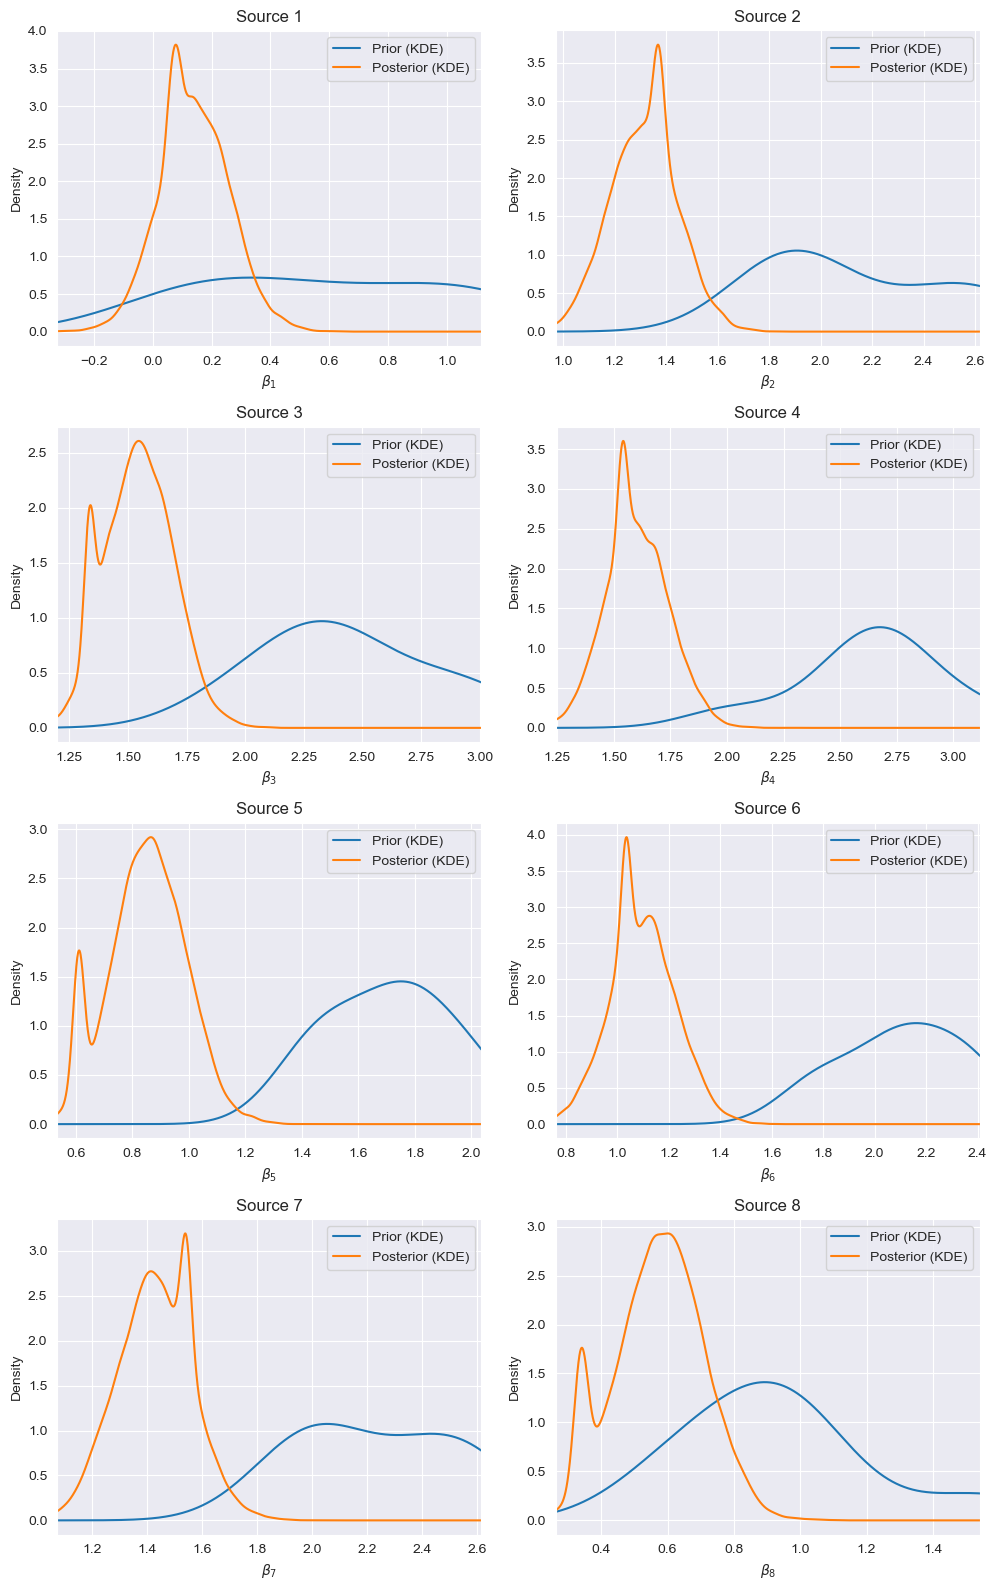

In [33]:
plot_df_prior_vs_posterior(idata, beta_df, density_cut=0.1)

In [ ]:
kl_vals = kl_prior_posterior_beta(df_sim, idata)
for s, kl in kl_vals.items():
    print(f"Source {s}: KL(posterior‖prior) = {kl:0.4f}")


In [36]:
kl_vals = kl_prior_posterior_beta(idata, beta_df)
for s, kl in kl_vals.items():
    print(f"Source {s}: KL(posterior‖prior) = {kl:0.4f}")

Source 1: KL(posterior‖prior) = 26.0608
Source 2: KL(posterior‖prior) = 28.2628
Source 3: KL(posterior‖prior) = 28.1044
Source 4: KL(posterior‖prior) = 28.1937
Source 5: KL(posterior‖prior) = 28.2742
Source 6: KL(posterior‖prior) = 28.2977
Source 7: KL(posterior‖prior) = 28.2163
Source 8: KL(posterior‖prior) = 26.9019


In [ ]:
stats = summarise_beta_prior_posterior(df_sim, idata,1)
print(stats)

# save to csv
stats.to_csv("beta_prior_posterior_stats.csv", index=False)


In [42]:
stats = summarise_beta_prior_posterior(idata, beta_df, kl_dict=kl_vals)

print(stats)
# save to csv
stats.to_csv("beta_prior_posterior_stats.csv", index=False)

   experiment source  prior_mean  prior_median  post_mean  post_median  \
0           1  beta1    0.590672      0.554161   0.139559     0.133519   
1           1  beta2    2.140443      1.964215   1.315612     1.323678   
2           1  beta3    2.426244      2.387686   1.540140     1.541046   
3           1  beta4    2.630574      2.702275   1.599535     1.589754   
4           1  beta5    1.706364      1.737943   0.846495     0.850850   
5           1  beta6    2.107370      2.093486   1.097011     1.090459   
6           1  beta7    2.235024      2.191087   1.429399     1.432864   
7           1  beta8    0.936264      0.936465   0.569750     0.574947   

   mean_error  median_error  kl_divergence  post_ci_lower  post_ci_upper  \
0    0.451113      0.420642      26.060839      -0.087195       0.381054   
1    0.824830      0.640537      28.262841       1.056171       1.573936   
2    0.886104      0.846640      28.104361       1.283087       1.828614   
3    1.031040      1.112520  

In [ ]:
'''
def summarise_beta_prior_posterior_sample(
        df_sim,
        idata,
        experiment: int = 1
):
    """
    For each β_s parameter compute

        • prior sample mean & median (raw `point` column of df_sim)
        • posterior sample mean, median, 95 % CI
        • flag : does the 95 % CI cover the prior sample mean?

    Returns
    -------
    pandas.DataFrame with columns
        source
        prior_mean prior_median
        post_mean post_median
        post_ci_lower post_ci_upper
        ci_covers_prior_mean
    """
    # ── locate β_s in the posterior ───────────────────────────────
    beta_vars = [v for v in idata.posterior.data_vars
                 if re.fullmatch(r"beta_\d+", v)]
    sources_avl = sorted(int(v.split("_")[1]) for v in beta_vars)
    if not sources_avl:
        raise ValueError("No beta_* variables found in idata.posterior")

    rows = []

    for s in sources_avl:
        # ── PRIOR sample statistics (raw grid points) -------------
        prior_samples = df_sim.loc[df_sim["source"] == s, "point"].values
        prior_mean = float(np.mean(prior_samples))
        prior_median = float(np.median(prior_samples))

        # ── POSTERIOR sample statistics ---------------------------
        post_samples = idata.posterior[f"beta_{s}"].values.flatten()
        post_mean = float(np.mean(post_samples))
        post_median = float(np.median(post_samples))
        ci_lower, ci_upper = np.percentile(post_samples, [2.5, 97.5])

        covers = (ci_lower <= prior_mean) and (prior_mean <= ci_upper)

        rows.append(dict(
            experiment=experiment,
            source=s,
            prior_mean=prior_mean,
            prior_median=prior_median,
            post_mean=post_mean,
            post_median=post_median,
            post_ci_lower=ci_lower,
            post_ci_upper=ci_upper,
            ci_covers_prior_mean=covers,
        ))

    return pd.DataFrame(rows)

stats = summarise_beta_prior_posterior(df_sim, idata, 1)
print(stats)
'''

## Experiment use likelihood

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import jax.random as random
import jax.numpy as jnp
import arviz as az
from numpyro.infer import MCMC, NUTS
from datetime import date



# ------------------------------------------------------------------
#  Main driver
# ------------------------------------------------------------------
def run_hdp_experiments(
    K: int,
    O: int,
    S: int,
    n_obs: int,
    N_sources: int,
    seed: int,
    output_base: str,
    *,
    num_warmup: int = 5000,
    num_samples: int = 20000,
    n_reps: int = 10,                 # ← how many repetitions (k times)
):
    """
    Run the complete HDP simulation / fitting experiment `n_reps` times for
    *each* of the three data-generating families: linear, Poisson, logistic.

    All artefacts are written beneath

        {output_base}/{model_type}/

    where `model_type` ∈ {"linear","poisson","logistic"}.
    A single CSV containing the concatenated summary statistics is produced
    for every model family.

    Parameters
    ----------
    K, O, S, n_obs
        Mixture, outcome & observation sizes to pass through to your
        simulate_profile_likelihoods_* helpers.
    N_sources
        Preset number of sources in the HDP.
    seed
        Global seed.  Repetition-specific seeds are derived from it so that no
        two repetitions ever share the same random stream.
    output_base
        Root directory in which all results will be stored.
    num_warmup, num_samples
        Sampler settings for the NUTS-based MCMC.
    n_reps
        Number of repetitions **per model family**.
    """

    today_str = date.today().isoformat()
    rng_master = np.random.default_rng(seed)

    # Map each model family to its simulator helper ---------------------------
    sim_fns = dict(
        linear   = simulate_profile_likelihoods_linreg,
        poisson  = simulate_profile_likelihoods_poisson,
        logistic = simulate_profile_likelihoods_logistic,
    )

    for model_type, sim_fn in sim_fns.items():
        model_dir = Path(output_base) / model_type
        fig_dir   = model_dir / "figures" / "beta_plots"
        data_dir  = model_dir / "data"
        fig_dir.mkdir(parents=True, exist_ok=True)

        stats_all   = []   # collects one DF per repetition
        kl_all      = []
        proportion_largest = []

        for rep in range(1, n_reps + 1):
            # ----------------------------------------------------------------
            # 1)  Data generation
            # ----------------------------------------------------------------
            rep_seed = rng_master.integers(seed+rep)
            rng_rep  = np.random.default_rng(rep_seed)

            grid_pts  = np.linspace(-10, 10, 100)
            beta_mean = rng_rep.normal(loc=1.5, scale=0.7, size=K)
            beta_sds  = np.abs(rng_rep.normal(loc=0.0, scale=1.0, size=K))

            # Simulator may have family-specific keyword parameters.
            sim_kwargs = dict(
                K=K, S=S, O=O, n_obs=n_obs,
                beta_mean=beta_mean,
                beta_sds=beta_sds,
                grid=grid_pts,
                seed=rep_seed,
            )
            if model_type == "linear":
                sim_kwargs["sigma_noise"] = 0.8

            df_sim, pis_true, df_betas = sim_fn(**sim_kwargs)

            # ----------------------------------------------------------------
            # 2)  Reshape into source-outcome dict expected by HDP_model
            # ----------------------------------------------------------------
            source_outcome_data = {}
            for s in range(1, N_sources + 1):
                df_s = df_sim[df_sim["source"] == s]
                outcome_list = []
                for o in sorted(df_s["outcome"].unique()):
                    arr = df_s[df_s["outcome"] == o][["point", "value"]].to_numpy()
                    outcome_list.append(jnp.array(arr))
                source_outcome_data[s] = outcome_list

            num_outcomes_dict = {s: len(source_outcome_data[s])
                                 for s in range(1, N_sources + 1)}

            # ----------------------------------------------------------------
            # 3)  Run HDP
            # ----------------------------------------------------------------
            rng_key = random.PRNGKey(rep_seed)
            data_point_mean = jnp.asarray(df_sim["point"].mean())

            nuts_kernel = NUTS(HDP_model)
            mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
            mcmc.run(
                rng_key,
                source_outcome_data=source_outcome_data,
                num_outcomes_dict=num_outcomes_dict,
                N_sources=N_sources,
                k=K,
                data_point_mean=data_point_mean,
            )
            idata = az.from_numpyro(mcmc)

            store_beta_posteriors(
                idata=idata,
                df_sim=df_sim,
                output_folder=data_dir/f"rep{rep}",
                file_ext="npz",      # or "npy"
                compress=True,
            )

            # ----------------------------------------------------------------
            # 4)  Save betas density histograms
            # ----------------------------------------------------------------
            save_beta_density_hist(
                idata,
                output_folder=str(fig_dir),
                experiment=f"rep{rep}",
            )

            # ----------------------------------------------------------------
            # 5)  Save PPC (prior vs posterior) comparison
            # ----------------------------------------------------------------
            ppc_path = model_dir / f"rep{rep}_ppc.png"
            ppc_obj  = plot_df_prior_vs_posterior(df_sim, idata, save_to=ppc_path)


            if isinstance(ppc_obj, plt.Figure):           # helper returns a Figure
                ppc_obj.savefig(ppc_path, dpi=300, bbox_inches="tight")
                plt.close(ppc_obj)

            elif hasattr(ppc_obj, "figure"):              # helper returns an Axes
                ppc_obj.figure.savefig(ppc_path, dpi=300, bbox_inches="tight")
                plt.close(ppc_obj.figure)

            else:
                # Helper already saved the plot (or user doesn’t need a file).
                # If you still want confirmation:
                print(f"  [info] plot_df_prior_vs_posterior returned {type(ppc_obj)}; "
                      "skipping explicit save.")

            # ----------------------------------------------------------------
            # 6)  KL divergence
            # ----------------------------------------------------------------
            kl_vals = kl_prior_posterior_beta(df_sim, idata)
            kl_vals["rep"] = rep          # keep track of repetition
            kl_all.append(kl_vals)

            # ----------------------------------------------------------------
            # 7)  Summary statistics
            # ----------------------------------------------------------------
            stats = summarise_beta_prior_posterior(df_sim, idata, kl_vals, experiment_label=f"rep{rep}")
            largest_info = largest_mean_pi_norm(idata, pis=pis)
            largest_df   = pd.DataFrame(largest_info).rename(columns={
                "component":      "largest_component",
                "mean_value":     "mean_pi_norm",
                "true_proportion":"true_max_pi",
                "source":         "src_zero",
            })

            # 3 ── create the join key in *stats*  (convert “beta1” → 0, “beta2” → 1, …)
            stats["src_zero"] = stats["source"].str.extract(r"(\d+)").astype(int) - 1

            # 4 ── merge and drop helper key
            stats = (
                stats
                  .merge(largest_df, on="src_zero", how="left")
                  .drop(columns="src_zero")
            )


            stats_all.append(stats)

            print(f"[{model_type}] repetition {rep} finished.")

        # --------------------------------------------------------------------
        #  Persist concatenated results for this model family
        # --------------------------------------------------------------------
        stats_df = pd.concat(stats_all, ignore_index=True)
        fname = model_dir / f"beta_summary_stats_{today_str}.csv"
        stats_df.to_csv(fname, index=False)


        print(f"\nCompleted all {n_reps} repetitions for '{model_type}'. "
              f"Results stored in: {model_dir}\n")
today_str = date.today().isoformat()
run_hdp_experiments(
    K=5, O=8, S=8, n_obs=120,
    N_sources=8,
    seed=42,
    output_base=f"results_likelihood_{}".format(today_str),
    num_warmup=5000,
    num_samples=20000,
    n_reps=100
)


## Experiment use sample

In [ ]:

# ------------------------------------------------------------------
#  Main driver
# ------------------------------------------------------------------
def run_hdp_experiments(
    K: int,
    O: int,
    S: int,
    n_obs: int,
    N_sources: int,
    seed: int,
    output_base: str,
    *,
    num_warmup: int = 5000,
    num_samples: int = 20000,
    n_reps: int = 10,                 # ← how many repetitions (k times)
):
    """
    Run the complete HDP simulation / fitting experiment `n_reps` times for
    *each* of the three data-generating families: linear, Poisson, logistic.

    All artefacts are written beneath

        {output_base}/{model_type}/

    where `model_type` ∈ {"linear","poisson","logistic"}.
    A single CSV containing the concatenated summary statistics is produced
    for every model family.

    Parameters
    ----------
    K, O, S, n_obs
        Mixture, outcome & observation sizes to pass through to your
        simulate_profile_likelihoods_* helpers.
    N_sources
        Preset number of sources in the HDP.
    seed
        Global seed.  Repetition-specific seeds are derived from it so that no
        two repetitions ever share the same random stream.
    output_base
        Root directory in which all results will be stored.
    num_warmup, num_samples
        Sampler settings for the NUTS-based MCMC.
    n_reps
        Number of repetitions **per model family**.
    """

    today_str = date.today().isoformat()
    rng_master = np.random.default_rng(seed)

    # Map each model family to its simulator helper ---------------------------
    sim_fns = dict(
        linear   = simulate_profile_likelihoods_linreg,
        poisson  = simulate_profile_likelihoods_poisson,
        logistic = simulate_profile_likelihoods_logistic,
    )

    for model_type, sim_fn in sim_fns.items():
        model_dir = Path(output_base) / model_type
        fig_dir   = model_dir / "figures" / "beta_plots"
        data_dir  = model_dir / "data"
        fig_dir.mkdir(parents=True, exist_ok=True)

        stats_all   = []   # collects one DF per repetition
        kl_all      = []
        proportion_largest = []

        for rep in range(1, n_reps + 1):
            # ----------------------------------------------------------------
            # 1)  Data generation
            # ----------------------------------------------------------------
            rep_seed = rng_master.integers(seed+rep)
            rng_rep  = np.random.default_rng(rep_seed)

            grid_pts  = np.linspace(-10, 10, 100)
            beta_mean = rng_rep.normal(loc=1.5, scale=0.7, size=K)
            beta_sds  = np.abs(rng_rep.normal(loc=0.0, scale=1.0, size=K))

            # Simulator may have family-specific keyword parameters.
            sim_kwargs = dict(
                K=K, S=S, O=O, n_obs=n_obs,
                beta_mean=beta_mean,
                beta_sds=beta_sds,
                grid=grid_pts,
                seed=rep_seed,
            )
            if model_type == "linear":
                sim_kwargs["sigma_noise"] = 0.8

            df_sim, pis_true, df_betas = sim_fn(**sim_kwargs)

            # ----------------------------------------------------------------
            # 2)  Reshape into source-outcome dict expected by HDP_model
            # ----------------------------------------------------------------
            source_outcome_data = {}
            for s in range(1, N_sources + 1):
                df_s = df_sim[df_sim["source"] == s]
                outcome_list = []
                for o in sorted(df_s["outcome"].unique()):
                    arr = df_s[df_s["outcome"] == o][["point", "value"]].to_numpy()
                    outcome_list.append(jnp.array(arr))
                source_outcome_data[s] = outcome_list

            num_outcomes_dict = {s: len(source_outcome_data[s])
                                 for s in range(1, N_sources + 1)}

            # ----------------------------------------------------------------
            # 3)  Run HDP
            # ----------------------------------------------------------------
            rng_key = random.PRNGKey(rep_seed)
            data_point_mean = jnp.asarray(df_sim["point"].mean())

            nuts_kernel = NUTS(HDP_model)
            mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
            mcmc.run(
                rng_key,
                source_outcome_data=source_outcome_data,
                num_outcomes_dict=num_outcomes_dict,
                N_sources=N_sources,
                k=K,
                data_point_mean=data_point_mean,
            )
            idata = az.from_numpyro(mcmc)

            store_beta_posteriors(
                idata=idata,
                df_sim=df_sim,
                beta_df=df_betas,
                output_folder=data_dir/f"rep{rep}",
                file_ext="npz",      # or "npy"
                compress=True,
            )

            # ----------------------------------------------------------------
            # 4)  Save betas density histograms
            # ----------------------------------------------------------------
            save_beta_density_hist(
                idata,
                output_folder=str(fig_dir),
                experiment=f"rep{rep}",
            )

            # ----------------------------------------------------------------
            # 5)  Save PPC (prior vs posterior) comparison
            # ----------------------------------------------------------------
            ppc_path = model_dir / f"rep{rep}_ppc.png"
            ppc_obj  = plot_df_prior_vs_posterior(idata, df_betas, save_to=ppc_path)


            if isinstance(ppc_obj, plt.Figure):           # helper returns a Figure
                ppc_obj.savefig(ppc_path, dpi=300, bbox_inches="tight")
                plt.close(ppc_obj)

            elif hasattr(ppc_obj, "figure"):              # helper returns an Axes
                ppc_obj.figure.savefig(ppc_path, dpi=300, bbox_inches="tight")
                plt.close(ppc_obj.figure)

            else:
                # Helper already saved the plot (or user doesn’t need a file).
                # If you still want confirmation:
                print(f"  [info] plot_df_prior_vs_posterior returned {type(ppc_obj)}; "
                      "skipping explicit save.")

            # ----------------------------------------------------------------
            # 6)  KL divergence
            # ----------------------------------------------------------------
            kl_vals = kl_prior_posterior_beta(idata, beta_df=df_betas)
            kl_vals["rep"] = rep          # keep track of repetition
            kl_all.append(kl_vals)

            # ----------------------------------------------------------------
            # 7)  Summary statistics
            # ----------------------------------------------------------------
            stats = summarise_beta_prior_posterior(idata, df_betas, kl_dict=kl_vals, experiment_label=f"rep{rep}")
            largest_info = largest_mean_pi_norm(idata, pis=pis)
            largest_df   = pd.DataFrame(largest_info).rename(columns={
                "component":      "largest_component",
                "mean_value":     "mean_pi_norm",
                "true_proportion":"true_max_pi",
                "source":         "src_zero",
            })

            # 3 ── create the join key in *stats*  (convert “beta1” → 0, “beta2” → 1, …)
            stats["src_zero"] = stats["source"].str.extract(r"(\d+)").astype(int) - 1

            # 4 ── merge and drop helper key
            stats = (
                stats
                  .merge(largest_df, on="src_zero", how="left")
                  .drop(columns="src_zero")
            )


            stats_all.append(stats)

            print(f"[{model_type}] repetition {rep} finished.")

        # --------------------------------------------------------------------
        #  Persist concatenated results for this model family
        # --------------------------------------------------------------------
        stats_df = pd.concat(stats_all, ignore_index=True)
        fname = model_dir / f"beta_summary_stats.csv"
        stats_df.to_csv(fname, index=False)


        print(f"\nCompleted all {n_reps} repetitions for '{model_type}'. "
              f"Results stored in: {model_dir}\n")

today_str = date.today().isoformat()
run_hdp_experiments(
    K=5, O=8, S=8, n_obs=120,
    N_sources=8,
    seed=42,
    output_base=f"results_sample_{today_str}",
    num_warmup=5000,
    num_samples=20000,
    n_reps=100
)

# Experiment Exact

In [ ]:
def run_hdp_experiments(
    K: int,
    O: int,
    S: int,
    n_obs: int,
    N_sources: int,
    seed: int,
    output_base: str,
    *,
    num_warmup: int = 5000,
    num_samples: int = 20000,
    n_reps: int = 10,
):
    """
    Run HDP experiments (linear, Poisson, logistic) n_reps times each,
    using exact (x,y)-based log-likelihoods.
    """

    today_str = date.today().isoformat()
    rng_master = np.random.default_rng(seed)

    # Map model families to your new simulators
    sim_fns = dict(
        #linear   = simulate_profile_likelihoods_linreg,
        poisson  = simulate_profile_likelihoods_poisson,
        logistic = simulate_profile_likelihoods_logistic,
    )

    for model_type, sim_fn in sim_fns.items():
        model_dir = Path(output_base) / model_type
        fig_dir   = model_dir / "figures" / "beta_plots"
        data_dir  = model_dir / "data"
        fig_dir.mkdir(parents=True, exist_ok=True)
        data_dir.mkdir(parents=True, exist_ok=True)

        stats_all = []
        kl_all    = []

        for rep in range(1, n_reps + 1):
            # 1) Data generation
            rep_seed = int(rng_master.integers(0, 2**31) ^ rep)
            rng_rep  = np.random.default_rng(rep_seed)

            beta_mean = rng_rep.normal(loc=1.5, scale=0.7, size=K)
            beta_sds  = np.abs(rng_rep.normal(loc=0, scale=1.0, size=K))

            sim_kwargs = dict(
                K=K, S=S, O=O, n_obs=n_obs,
                beta_mean=beta_mean,
                beta_sds=beta_sds,
                seed=rep_seed,
            )
            # for linear only:
            if model_type == "linear":
                sim_kwargs["sigma_noise"] = 0.8
            if model_type == "logistic":
                n_obs = 1000

            # each sim_fn now returns df_sim (with x,y), pis_true, beta_df
            df_sim, pis_true, df_betas = sim_fn(**sim_kwargs)

            # 2) Build source_outcome_data from raw x/y arrays
            source_outcome_data = {}
            for s in range(1, N_sources + 1):
                df_s = df_sim[df_sim["source"] == s]
                outcome_list = []
                for o in sorted(df_s["outcome"].unique()):
                    group = df_s[df_s["outcome"] == o]
                    x_raw = group["x"].iloc[0]
                    y_raw = group["y"].iloc[0]
                    outcome_list.append((jnp.array(x_raw), jnp.array(y_raw)))
                source_outcome_data[s] = outcome_list

            # 3) Run HDP
            rng_key = random.PRNGKey(rep_seed)
            nuts   = NUTS(HDP_model)
            mcmc   = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples)
            mcmc.run(
                rng_key,
                source_outcome_data=source_outcome_data,
                N_sources=N_sources,
                k=K,
                model_type=model_type,
                sigma_noise=0.8 if model_type=="linear" else None
            )
            idata = az.from_numpyro(mcmc)

            # 4) Store β‐posteriors (with x,y under the hood)
            store_beta_posteriors(
                idata=idata,
                df_sim=df_sim,
                beta_df=df_betas,
                output_folder=data_dir/f"rep{rep}",
                file_ext="npz",
                compress=True,
            )

            # 5) Plot β‐densities
            save_beta_density_hist(
                idata,
                output_folder=str(fig_dir),
                experiment=f"rep{rep}",
            )

            # 6) PPC (prior vs posterior)
            ppc_obj = plot_df_prior_vs_posterior(idata, df_betas,
                                                 save_to=model_dir/f"rep{rep}_ppc.png")
            if hasattr(ppc_obj, "savefig"):
                ppc_obj.savefig(model_dir/f"rep{rep}_ppc.png", dpi=300, bbox_inches="tight")
                plt.close(ppc_obj)

            # 7) KL & summary stats
            kl_vals = kl_prior_posterior_beta(idata, beta_df=df_betas)
            kl_vals["rep"] = rep
            kl_all.append(kl_vals)

            stats = summarise_beta_prior_posterior(
                idata, df_betas, kl_dict=kl_vals, experiment_label=f"rep{rep}"
            )
            stats_all.append(stats)

            print(f"[{model_type}] rep {rep} done.")

        # save out
        pd.concat(stats_all, ignore_index=True) \
          .to_csv(model_dir/"beta_summary_stats.csv", index=False)

        print(f"Finished {n_reps} reps for '{model_type}'. "
              f"Results in {model_dir}\n")

#folder_name = f"results_exact_{date.today().isoformat()}"
folder_name = "results_exact_2025-06-14"
run_hdp_experiments(
        K=5, O=8, S=8, n_obs=120,
        N_sources=8,
        seed=42,
        output_base=folder_name,
        num_warmup=5000,
        num_samples=20000,
        n_reps=100
    )

sample: 100%|██████████| 25000/25000 [05:03<00:00, 82.45it/s, 70 steps of size 3.18e-02. acc. prob=0.51]  


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep1
Saved experiment rep1 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 1 done.


sample: 100%|██████████| 25000/25000 [02:29<00:00, 167.44it/s, 63 steps of size 7.37e-02. acc. prob=0.79]


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep2
Saved experiment rep2 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 2 done.


sample: 100%|██████████| 25000/25000 [02:25<00:00, 171.47it/s, 63 steps of size 5.99e-02. acc. prob=0.82] 


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep3
Saved experiment rep3 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 3 done.


sample: 100%|██████████| 25000/25000 [08:28<00:00, 49.17it/s, 255 steps of size 1.42e-02. acc. prob=0.86] 


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep4
Saved experiment rep4 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 4 done.


sample: 100%|██████████| 25000/25000 [02:41<00:00, 154.59it/s, 8 steps of size 5.28e-02. acc. prob=0.87]  


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep5
Saved experiment rep5 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 5 done.


sample: 100%|██████████| 25000/25000 [01:44<00:00, 238.56it/s, 31 steps of size 9.64e-02. acc. prob=0.76]


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep6
Saved experiment rep6 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 6 done.


sample: 100%|██████████| 25000/25000 [02:22<00:00, 175.69it/s, 17 steps of size 5.85e-02. acc. prob=0.85] 


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep7
Saved experiment rep7 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 7 done.


sample: 100%|██████████| 25000/25000 [03:05<00:00, 134.75it/s, 45 steps of size 5.12e-02. acc. prob=0.41] 


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep8
Saved experiment rep8 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 8 done.


sample: 100%|██████████| 25000/25000 [02:41<00:00, 154.76it/s, 31 steps of size 6.53e-02. acc. prob=0.74] 


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep9
Saved experiment rep9 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 9 done.


sample: 100%|██████████| 25000/25000 [02:28<00:00, 168.12it/s, 25 steps of size 6.00e-02. acc. prob=0.85] 


Stored 8 β‐posteriors in results_exact_2025-06-14\poisson\data\rep10
Saved experiment rep10 beta densities to results_exact_2025-06-14\poisson\figures\beta_plots
[poisson] rep 10 done.


sample: 100%|█████████▉| 24971/25000 [07:38<00:00, 50.17it/s, 155 steps of size 1.79e-02. acc. prob=0.87] 

In [62]:
# plot_hdp_stats.py
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

RESULTS_ROOT = Path(folder_name)            # adjust if you saved elsewhere
FAMILIES     = ["linear", "poisson", "logistic"]
OUT_FIG_DIR  = RESULTS_ROOT / "figures"
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)

# define your fixed color mapping
palette = {
    "linear":   "#4c72b0",   # blue
    "logistic": "#dd8452",   # brown/orange
    "poisson":  "#55a868",   # green
}

def newest_csv(model_dir: Path) -> Path | None:
    csvs = sorted(model_dir.glob("beta_summary_stats.csv"))
    return csvs[-1] if csvs else None

# -------------------------------------------------------------------------
# 1)  Load & combine
# -------------------------------------------------------------------------
frames = []
for fam in FAMILIES:
    mdl_dir = RESULTS_ROOT / fam
    csv     = newest_csv(mdl_dir)
    if csv is None:
        print(f"[warn] No summary CSV in {mdl_dir}; skipping.")
        continue

    df = pd.read_csv(csv)
    df["model_type"] = fam
    frames.append(df)

stats_all = pd.concat(frames, ignore_index=True)

# -------------------------------------------------------------------------
# 2)  Box‐plots for errors & KL
# -------------------------------------------------------------------------
sns.set_theme(style="whitegrid")

metrics = ["mean_error", "median_error", "kl_divergence"]
for metric in metrics:
    g = sns.catplot(
        data=stats_all,
        x="source", y=metric, hue="model_type",
        hue_order=FAMILIES,
        palette=palette,
        kind="box", height=5, aspect=1.8,
        showfliers=False,
    )
    g.set_axis_labels("β parameter (source)", metric.replace("_", " ").title())
    g.fig.suptitle(f"Distribution of {metric.replace('_',' ')} across repetitions")
    g.tight_layout()
    g.savefig(OUT_FIG_DIR / f"{metric}_boxplot.png", dpi=300)
    plt.close(g.fig)

# -------------------------------------------------------------------------
# 3)  Coverage‐rate bar‐plot
# -------------------------------------------------------------------------
coverage = (
    stats_all
      .groupby(["model_type", "source"])["ci_covers_prior_mean"]
      .mean()
      .reset_index(name="coverage_rate")
)

g = sns.catplot(
    data=coverage,
    x="source", y="coverage_rate", hue="model_type",
    hue_order=FAMILIES,
    palette=palette,
    kind="bar", height=5, aspect=1.8
)
g.set_axis_labels("β parameter (source)", "Coverage rate")
g.set(ylim=(0, 1))
g.fig.suptitle("95 % CI Coverage Rate")
g.tight_layout()
g.savefig(OUT_FIG_DIR / "ci_coverage_barplot.png", dpi=300)
plt.close(g.fig)

print(f"✓ Figures saved to: {OUT_FIG_DIR.resolve()}")

✓ Figures saved to: D:\Pycharm_Projects\results_2025-06-11\figures


## Compare Likelihoods for Different Method

In [ ]:
# compare_likelihoods.py

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from pathlib import Path
from math import ceil

# ── CONFIG ────────────────────────────────────────────────────────────────
RESULTS_ROOT = Path("results_2025-06-09")  # adjust if needed
MODELS       = ["linear", "poisson", "logistic"]
PALETTE      = {
    "linear":   "#4c72b0",
    "poisson":  "#55a868",
    "logistic": "#dd8452",
}
DATA_SUBDIR  = "data"
OUT_DIR      = RESULTS_ROOT / "figures" / "likelihood_comparison"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DENSITY_CUT = 1e-3  # only keep regions where ≥1 method has density > cut

# ── HELPER ────────────────────────────────────────────────────────────────
def plot_likelihoods_for_rep(rep_path: Path):
    """
    For a single rep directory, load all beta_<s>.npz for each model,
    then create a grid of subplots (one per source) overlaying the
    three normalized likelihoods (with mask trimming) and a shared legend.
    """
    rep = rep_path.name  # e.g. "rep1"
    # gather the list of sources by looking at one model’s files
    bundle_files = sorted(rep_path.glob("beta_*.npz"))
    sources = [f.stem for f in bundle_files]  # ["beta_1", "beta_2", ...]

    n = len(sources)
    ncols = 2
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()

    for idx, beta_var in enumerate(sources):
        ax = axes[idx]
        mask = None
        x_min_list, x_max_list = [], []

        for model in MODELS:
            path = RESULTS_ROOT / model / DATA_SUBDIR / rep / f"{beta_var}.npz"
            data = np.load(path)
            grid   = data["grid"]
            loglik = data["loglik"]

            # normalize log-lik to density
            ll0   = loglik - loglik.max()
            dens  = np.exp(ll0)
            dens /= trapezoid(dens, grid)

            # update ranges and mask
            x_min_list.append(grid.min())
            x_max_list.append(grid.max())
            this_mask = dens > DENSITY_CUT
            mask = this_mask if mask is None else (mask | this_mask)

            # plot
            ax.plot(
                grid, dens,
                label=model.capitalize(),
                color=PALETTE[model],
                linewidth=1.2
            )

        # apply mask to trim x-axis
        if mask is not None and mask.any():
            x0, x1 = grid[mask].min(), grid[mask].max()
        else:
            x0, x1 = min(x_min_list), max(x_max_list)
        ax.set_xlim(x0, x1)

        # labels
        s = beta_var.split("_", 1)[1]
        ax.set_title(f"Source {s}")
        ax.set_xlabel(rf"$\beta_{{{s}}}$")
        ax.set_ylabel("Density")
        ax.grid(True)

    # hide unused axes
    for ax in axes[n:]:
        ax.axis("off")

    # adjust to make room for legend & title
    fig.subplots_adjust(top=0.88)

    # shared legend above subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.96),
        ncol=len(MODELS),
        frameon=False,
    )

    # super‐title in the top margin
    fig.suptitle(f"Likelihood comparison — {rep}", y=0.99, fontsize=14)

    # ensure subplots occupy only the region below the legend/title
    fig.tight_layout(rect=[0, 0, 1, 0.88])

    # save
    out_path = OUT_DIR / f"{rep}_all_sources_likelihoods.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"✓ saved {out_path.name}")



reps = sorted((RESULTS_ROOT / MODELS[0] / DATA_SUBDIR).glob("rep*"))
for rep_path in reps:
    plot_likelihoods_for_rep(rep_path)
print(f"\nAll comparison plots saved under: {OUT_DIR}")


In [64]:
def plot_prior_and_likelihood_from_bundle(bundle: dict[str, np.ndarray], density_cut: float = 1e-3) -> plt.Figure:
    """
    Plot the prior KDE and normalized likelihood, trimming the x-axis
    to the region where either density exceeds `density_cut`.
    
    Parameters
    ----------
    bundle : dict[str, np.ndarray]
        Must contain:
          - 'prior_samples': 1-D array of β_true draws
          - 'grid'         : 1-D array of grid points
          - 'loglik'       : 1-D array of summed log-lik at each grid point
    density_cut : float
        Threshold for trimming the x-axis based on max(prior, likelihood).
    """
    prior = bundle["prior_samples"]
    grid  = bundle["grid"]
    ll    = bundle["loglik"]

    # KDE for the prior
    kde_prior = gaussian_kde(prior)

    # Normalize likelihood into a density
    ll0   = ll - ll.max()
    lik   = np.exp(ll0)
    lik_d = lik / trapezoid(lik, grid)

    # Build fine x-axis
    x_min = min(prior.min(), grid.min())
    x_max = max(prior.max(), grid.max())
    x = np.linspace(x_min, x_max, 1000)

    # Evaluate densities on the fine grid
    p_prior = kde_prior(x)
    p_lik   = np.interp(x, grid, lik_d, left=0, right=0)

    # Mask for trimming
    mask = np.maximum(p_prior, p_lik) > density_cut
    if mask.any():
        x0, x1 = x[mask].min(), x[mask].max()
    else:
        x0, x1 = x_min, x_max

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x, p_prior, label="Prior (KDE)")
    ax.plot(x, p_lik, label="Normalized Likelihood")
    ax.set_xlim(x0, x1)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    return fig
def generate_all_prior_vs_like(base_folder=None):
    base = Path(base_folder)
    for model_type in ("linear", "poisson", "logistic"):
        data_root = base / model_type / "data"
        out_dir   = base / model_type / "figures" / "prior_vs_likelihood"
        out_dir.mkdir(parents=True, exist_ok=True)
        count = 0
        
        for rep_dir in sorted(data_root.glob("rep*")):
            bundles = load_beta_posteriors(rep_dir, file_ext="npz")
            for varname, bundle in bundles.items():
                fig = plot_prior_and_likelihood_from_bundle(bundle)
                fname = f"{rep_dir.name}_{varname}_prior_vs_likelihood.png"
                fig.savefig(out_dir / fname, dpi=300, bbox_inches="tight")
                plt.close(fig)
            count += 1
            # print every 50 times
            if count % 50 == 0:
                print(f"Processed {count} repetitions for {model_type}.")
            
            
generate_all_prior_vs_like(base_folder="results")



Loaded 8 β‐posterior archives from results_2025-06-11\linear\data\rep1


KeyError: 'grid'